### Setup

In [1]:
%cd
%cd neuraluq-CSproject 
!ls

/home/ilaria
/home/ilaria/neuraluq-CSproject
build	 dist	   neuraluq	      README.md  setup.py
dataset  examples  NeuralUQ.egg-info  scripts


In [2]:
!python setup.py install

/home/ilaria/anaconda3/lib/python3.9/site-packages/setuptools/dist.py:530: UserWarning: Normalizing 'v0.1.0-beta' to '0.1.0b0'
  warnings.warn(tmpl.format(**locals()))
running install
/home/ilaria/anaconda3/lib/python3.9/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/home/ilaria/anaconda3/lib/python3.9/site-packages/setuptools/command/easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running bdist_egg
running egg_info
writing NeuralUQ.egg-info/PKG-INFO
writing dependency_links to NeuralUQ.egg-info/dependency_links.txt
writing top-level names to NeuralUQ.egg-info/top_level.txt
reading manifest file 'NeuralUQ.egg-info/SOURCES.txt'
writing manifest file 'NeuralUQ.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install

### Import Libraries

In [55]:
import neuraluq as neuq
import neuraluq.variables as neuq_vars
from neuraluq.config import tf

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

Lotka Volterra equations:
$$ \frac{dx}{dt}=ax-bxy \\
\frac{dy}{dt}=-cy+dxy-eyz \\
\frac{dz}{dt}=-fz+gyz $$

Initial conditions are:
$$ x(0)=y(0)=z(0)=1$$

Reference values of the parameters are:
$ a = 1$, $b = 2$, $c = 2$, $d = 2$, $e = 1$, $f = 2$, $g = 3 $


In [56]:
def ode_fn(t, u, a, b, c, d, e, f, g):
    u1, u2, u3 = tf.split(u, 3, axis=-1)
    u1_t = tf.gradients(u1, t)[0]
    u2_t = tf.gradients(u2, t)[0]
    u3_t = tf.gradients(u3, t)[0]
    
# Lotka-Volterra
    f1 = u1_t - a*u1 + b*u1*u2
    f2 = u2_t + c*u2 - d*u1*u2 + e*u2*u3
    f3 = u3_t + f*u3 - g*u2*u3
    return tf.concat([f1, f2, f3], axis=-1)

## Lotka Volterra [0]
Dataset with the same structure as the example of KO

### Functions

In [5]:
def load_data():
    data = sio.loadmat("scripts/lotka_volterra_dataset.mat")
    t_test, u_test = data["t_test"], data["u_test"]
    t_u_train, u_train = data["t_u_train"], data["u_train"]
    t_f_train, f_train = data["t_f_train"], data["f_train"]
    noise = 0.05
    return t_u_train, u_train, t_f_train, f_train, noise, t_test, u_test

In [6]:
def save_params(k1_pred, k2_pred, k3_pred, k4_pred, k5_pred, k6_pred, k7_pred):
    np.save('scripts/params/dataset0_a', k1_pred)
    np.save('scripts/params/dataset0_b', k2_pred)
    np.save('scripts/params/dataset0_c', k3_pred)
    np.save('scripts/params/dataset0_d', k4_pred)
    np.save('scripts/params/dataset0_e', k5_pred)
    np.save('scripts/params/dataset0_f', k6_pred)
    np.save('scripts/params/dataset0_g', k7_pred)

In [7]:
@neuq.utils.timer
def Samplable(t_u_train, u_train, t_f_train, f_train, noise, layers):  
    u1_train, u3_train = u_train[:, 0:1], u_train[:, 2:3]
    t2_train, u2_train = t_u_train[:7], u_train[:7, 1:2]
    # build processes
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        prior=neuq_vars.fnn.Samplable(layers=layers, mean=0, sigma=1),
    )
    # I build the same process for all the parameters...
    process_k1 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k2 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k3 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k4 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k5 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k6 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k7 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    
    # build likelihood
    likelihood_u13 = neuq.likelihoods.Normal(
        inputs=t_u_train,
        targets=np.concatenate([u1_train, u3_train], axis=-1),
        processes=[process_u],
        out_dims=[[0, 2]],
        sigma=noise,
    )
    likelihood_u2 = neuq.likelihoods.Normal(
        inputs=t2_train,
        targets=u2_train,
        processes=[process_u],
        out_dims=[[1]],
        sigma=noise,
    )
    likelihood_f = neuq.likelihoods.Normal(
        inputs=t_f_train,
        targets=f_train,
        processes=[process_u, process_k1, process_k2, process_k3, process_k4, process_k5, process_k6, process_k7],
        pde=ode_fn,
        sigma=noise,
    )
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_k1, process_k2, process_k3, process_k4, process_k5, process_k6, process_k7],
        likelihoods=[likelihood_u13, likelihood_u2, likelihood_f],
    )
    # assign and compile method
    # Change parameters to make the acceptance rate close to 0.6.
    method = neuq.inferences.HMC(                                         
        num_samples=1000,
        num_burnin=5000,
        init_time_step=0.1,
        leapfrog_step=50,
        seed=777,
    )
    model.compile(method)
    # obtain posterior samples
    samples, results = model.run()
    print("Acceptance rate: %.3f \n"%(np.mean(results)))

    processes = [process_u, process_k1, process_k2, process_k3, process_k4, process_k5, process_k6, process_k7]
    return processes, samples, model


In [8]:
def plots(u_pred, t_test, u_test, t_u_train, u_train):
    u1_pred, u2_pred, u3_pred = np.split(u_pred, 3, axis=-1)
    u1_test, u2_test, u3_test = np.split(u_test, 3, axis=-1)
    u1_train, u3_train = u_train[:, 0:1], u_train[:, 2:3]  # training data
    t2_train, u2_train = t_u_train[:7], u_train[:7, 1:2]  # training data

  # plot parameters' histograms
    neuq.utils.hist(k1_pred, name="value of $k1$")
    neuq.utils.hist(k2_pred, name="value of $k2$")
    neuq.utils.hist(k3_pred, name="value of $k3$")
    neuq.utils.hist(k4_pred, name="value of $k4$")
    neuq.utils.hist(k5_pred, name="value of $k5$")
    neuq.utils.hist(k6_pred, name="value of $k6$")
    neuq.utils.hist(k7_pred, name="value of $k7$")
  
  # plot x1, x2, x3
    neuq.utils.plot1d(
        t_u_train,
        u1_train,
        t_test,
        u1_test,
        u1_pred[..., 0],
        title="inference over mode 1",
        xlim=[0, 10],
        ylim=[0.4, 2.7],
    )
    neuq.utils.plot1d(
        t2_train,
        u2_train,
        t_test,
        u2_test,
        u2_pred[..., 0],
        title="inference over mode 2",
        xlim=[0, 10],
        ylim=[0, 2.5],
    )
    neuq.utils.plot1d(
        t_u_train,
        u3_train,
        t_test,
        u3_test,
        u3_pred[..., 0],
        title="inference over mode 3",
        xlim=[0, 10],
        ylim=[0, 1.1],
    )

In [10]:
def plot_equations2(k1_pred, k2_pred, k3_pred, k4_pred, k5_pred, k6_pred, k7_pred):
    
    def system(t, vars, a, b, c, d, e, f, g):
        x, y, z = vars
        dxdt = a*x - b*x*y
        dydt = -c*y + d*x*y - e*y*z
        dzdt = -f*z + g*y*z
        return [dxdt, dydt, dzdt]

    # Set the parameters
    a = k1_pred.mean()
    b = k2_pred.mean()
    c = k3_pred.mean()
    d = k4_pred.mean()
    e = k5_pred.mean()
    f = k6_pred.mean()
    g = k7_pred.mean()

    std = max(k1_pred.var(), k2_pred.var(), k3_pred.var(), k4_pred.var(), k5_pred.var(), k6_pred.var(), k7_pred.var())

    # Set the initial conditions
    init_cond = [1, 1, 1]

    # Set the time span
    t_span = [0, 10]
    t_ev = np.linspace(0, 10, 100)

    # Solve the ODEs
    sol = solve_ivp(system, t_span, init_cond, t_eval=t_ev, args=(a, b, c, d, e, f, g))
    solt = solve_ivp(system, t_span, init_cond, t_eval=t_ev, args=(1, 2, 2, 2, 1, 2, 3))

    # Print the solution
    fig, axs = plt.subplots(3, 1, figsize=(8,12))
    axs[0].plot(sol.t, sol.y[0], 'r-', label='x(t) simulated')
    axs[0].plot(solt.t, solt.y[0], 'r--', label='x(t)')
    axs[0].fill_between(sol.t, sol.y[0] - std, sol.y[0] + std, alpha=0.3, facecolor='c')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('x')
    axs[0].legend(loc='upper right')

    axs[1].plot(sol.t, sol.y[1], 'b-', label='y(t) simulated')
    axs[1].plot(solt.t, solt.y[1], 'b--', label='y(t)')
    axs[1].fill_between(sol.t, sol.y[1] - std, sol.y[1] + std, alpha=0.3, facecolor='c')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('y')
    axs[1].legend(loc='upper right')

    axs[2].plot(sol.t, sol.y[2], 'g-', label='z(t) simulated')
    axs[2].plot(solt.t, solt.y[2], 'g--', label='z(t)')
    axs[2].fill_between(sol.t, sol.y[2] - std, sol.y[2] + std, alpha=0.3, facecolor='c')
    axs[2].set_xlabel('Time')
    axs[2].set_ylabel('z')
    axs[2].legend(loc='upper right')

    plt.show()

### Model and prediction

In [11]:
################## Load data and specify some hyperparameters ####################

data = load_data()
t_u_train, u_train, t_f_train, f_train, noise = data[:5]
t_test, u_test = data[5:]
layers = [1, 50, 50, 3]

processes, samples, model = Samplable(
    t_u_train, u_train, t_f_train, f_train, noise, layers
)

2023-03-22 08:38:35.777558: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-22 08:38:35.777639: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ilaria-UX310UQK): /proc/driver/nvidia/version does not exist
2023-03-22 08:38:35.779011: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 08:38:35.791812: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


Supporting backend tensorflow.compat.v1

Compiling a MCMC method

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

Acceptance rate: 0.670 

Execution time for 'Samplable' function is: 247.048 s, 4.117 mins


In [12]:
################################# Predictions ####################################
u_pred, k1_pred, k2_pred, k3_pred, k4_pred, k5_pred, k6_pred, k7_pred = model.predict(t_test, samples, processes, pde_fn=None)

In [13]:
save_params(k1_pred, k2_pred, k3_pred, k4_pred, k5_pred, k6_pred, k7_pred)

### Postprocessing

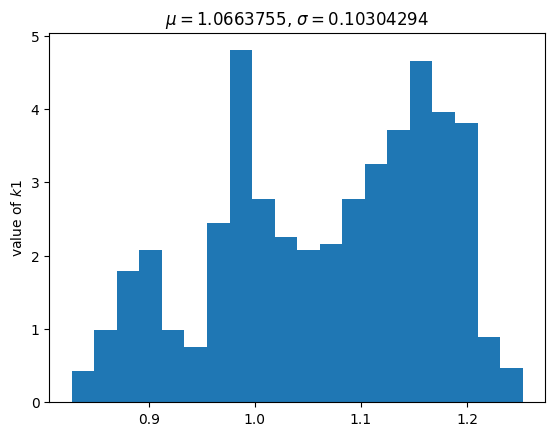

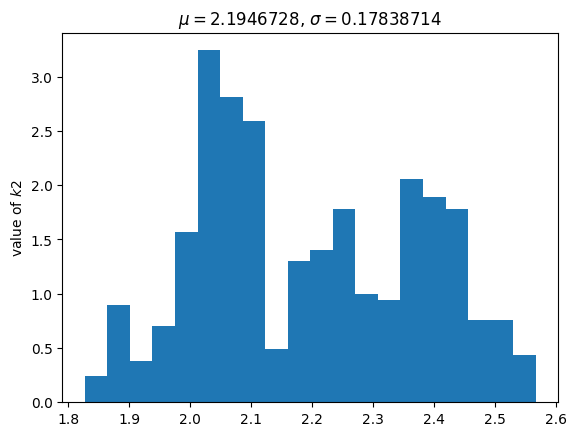

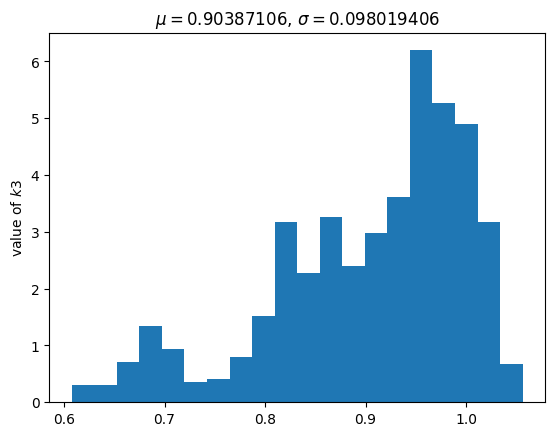

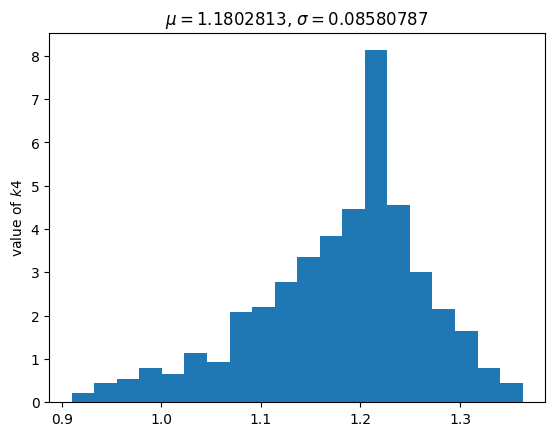

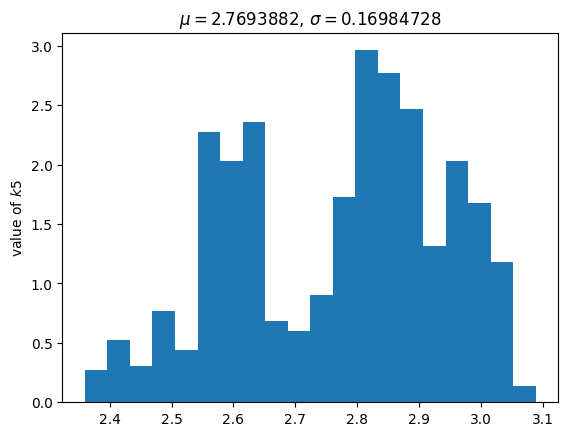

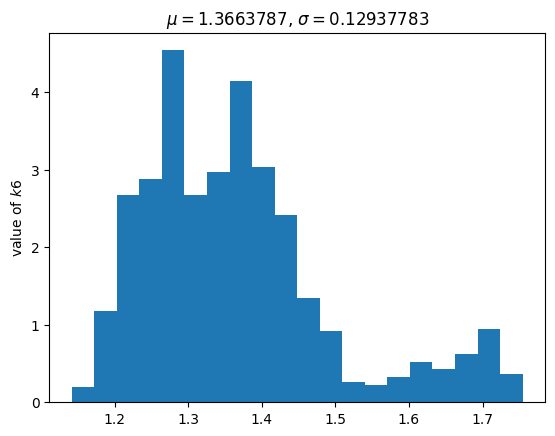

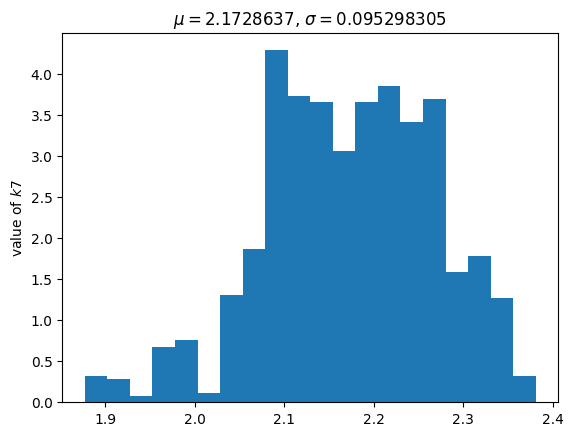

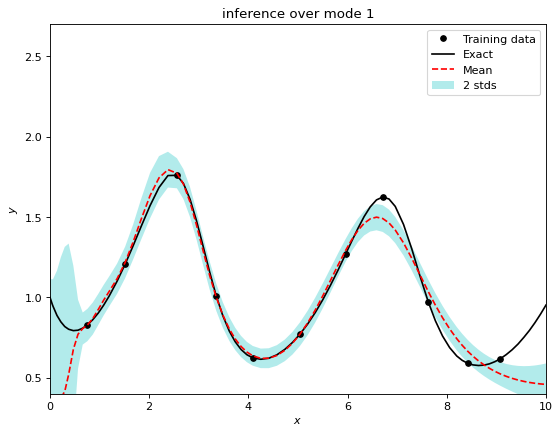

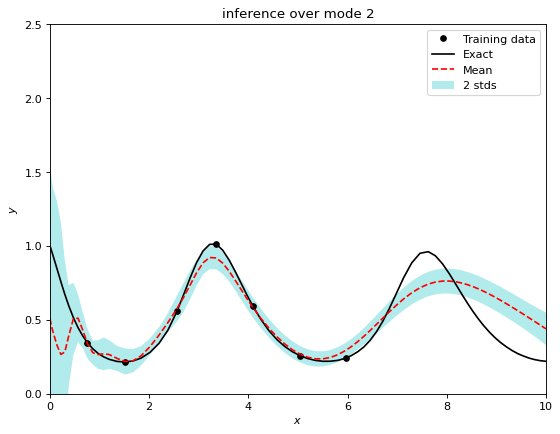

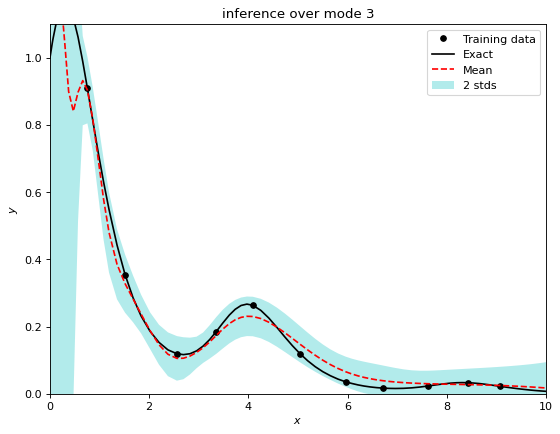

In [14]:
############################### Postprocessing ###################################
plots(u_pred, t_test, u_test, t_u_train, u_train)

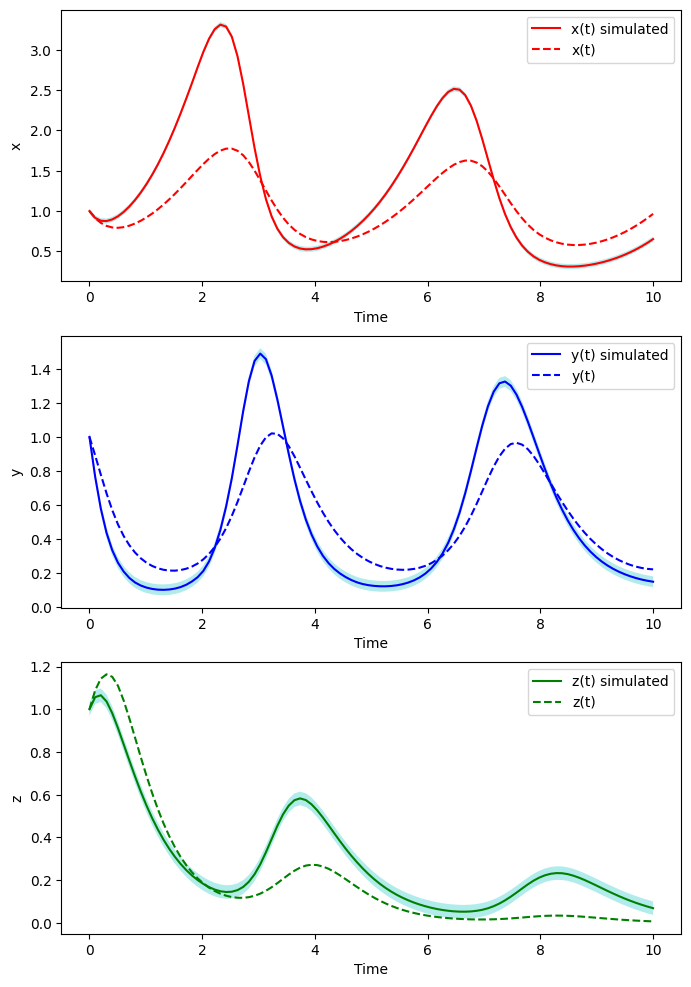

In [16]:
plot_equations2(k1_pred, k2_pred, k3_pred, k4_pred, k5_pred, k6_pred, k7_pred)

## Lotka Volterra [1]
time interval [0, 10]

### Functions

In [17]:
def load_data():
    data = sio.loadmat("scripts/lotka_volterra_dataset_1.mat")
    t_test, u_test = data["t_test"], data["u_test"]
    t_u_train, u_train = data["t_u_train"], data["u_train"]
    t_f_train, f_train = data["t_f_train"], data["f_train"]
    noise = 0.05
    return t_u_train, u_train, t_f_train, f_train, noise, t_test, u_test

In [18]:
def save_params(k1_pred, k2_pred, k3_pred, k4_pred, k5_pred, k6_pred, k7_pred):
    np.save('scripts/params/dataset1_a', k1_pred)
    np.save('scripts/params/dataset1_b', k2_pred)
    np.save('scripts/params/dataset1_c', k3_pred)
    np.save('scripts/params/dataset1_d', k4_pred)
    np.save('scripts/params/dataset1_e', k5_pred)
    np.save('scripts/params/dataset1_f', k6_pred)
    np.save('scripts/params/dataset1_g', k7_pred)

In [19]:
@neuq.utils.timer
def Samplable(t_u_train, u_train, t_f_train, f_train, noise, layers):  
    u1_train, u3_train = u_train[:, 0:1], u_train[:, 2:3]
    t2_train, u2_train = t_u_train[:18], u_train[:18, 1:2]
    # build processes
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        prior=neuq_vars.fnn.Samplable(layers=layers, mean=0, sigma=1),
    )
    # I build the same process for all the parameters...
    process_k1 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k2 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k3 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k4 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k5 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k6 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k7 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    
    # build likelihood
    likelihood_u13 = neuq.likelihoods.Normal(
        inputs=t_u_train,
        targets=np.concatenate([u1_train, u3_train], axis=-1),
        processes=[process_u],
        out_dims=[[0, 2]],
        sigma=noise,
    )
    likelihood_u2 = neuq.likelihoods.Normal(
        inputs=t2_train,
        targets=u2_train,
        processes=[process_u],
        out_dims=[[1]],
        sigma=noise,
    )
    likelihood_f = neuq.likelihoods.Normal(
        inputs=t_f_train,
        targets=f_train,
        processes=[process_u, process_k1, process_k2, process_k3, process_k4, process_k5, process_k6, process_k7],
        pde=ode_fn,
        sigma=noise,
    )
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_k1, process_k2, process_k3, process_k4, process_k5, process_k6, process_k7],
        likelihoods=[likelihood_u13, likelihood_u2, likelihood_f],
    )
    # assign and compile method
    # Change parameters to make the acceptance rate close to 0.6.
    method = neuq.inferences.HMC(                                         
        num_samples=1000,
        num_burnin=5000,
        init_time_step=0.1,
        leapfrog_step=50,
        seed=777,
    )
    model.compile(method)
    # obtain posterior samples
    samples, results = model.run()
    print("Acceptance rate: %.3f \n"%(np.mean(results)))

    processes = [process_u, process_k1, process_k2, process_k3, process_k4, process_k5, process_k6, process_k7]
    return processes, samples, model

In [20]:
def plots(u_pred, t_test, u_test, t_u_train, u_train):
    u1_pred, u2_pred, u3_pred = np.split(u_pred, 3, axis=-1)
    u1_test, u2_test, u3_test = np.split(u_test, 3, axis=-1)
    u1_train, u3_train = u_train[:, 0:1], u_train[:, 2:3]  # training data
    t2_train, u2_train = t_u_train[:18], u_train[:18, 1:2]  # training data

  # plot parameters' histograms
    neuq.utils.hist(k1_pred, name="value of $k1$")
    neuq.utils.hist(k2_pred, name="value of $k2$")
    neuq.utils.hist(k3_pred, name="value of $k3$")
    neuq.utils.hist(k4_pred, name="value of $k4$")
    neuq.utils.hist(k5_pred, name="value of $k5$")
    neuq.utils.hist(k6_pred, name="value of $k6$")
    neuq.utils.hist(k7_pred, name="value of $k7$")
  
  # plot x1, x2, x3
    neuq.utils.plot1d(
        t_u_train,
        u1_train,
        t_test,
        u1_test,
        u1_pred[..., 0],
        title="inference over mode 1",
        xlim=[0, 10],
        ylim=[0, 2],
    )
    neuq.utils.plot1d(
        t2_train,
        u2_train,
        t_test,
        u2_test,
        u2_pred[..., 0],
        title="inference over mode 2",
        xlim=[0, 10],
        ylim=[0, 2],
    )
    neuq.utils.plot1d(
        t_u_train,
        u3_train,
        t_test,
        u3_test,
        u3_pred[..., 0],
        title="inference over mode 3",
        xlim=[0, 10],
        ylim=[0, 2],
    )

In [22]:
def plot_equations2(k1_pred, k2_pred, k3_pred, k4_pred, k5_pred, k6_pred, k7_pred):
    
    def system(t, vars, a, b, c, d, e, f, g):
        x, y, z = vars
        dxdt = a*x - b*x*y
        dydt = -c*y + d*x*y - e*y*z
        dzdt = -f*z + g*y*z
        return [dxdt, dydt, dzdt]

    # Set the parameters
    a = k1_pred.mean()
    b = k2_pred.mean()
    c = k3_pred.mean()
    d = k4_pred.mean()
    e = k5_pred.mean()
    f = k6_pred.mean()
    g = k7_pred.mean()

    std = max(k1_pred.var(), k2_pred.var(), k3_pred.var(), k4_pred.var(), k5_pred.var(), k6_pred.var(), k7_pred.var())

    # Set the initial conditions
    init_cond = [1, 1, 1]

    # Set the time span
    t_span = [0, 10]
    t_ev = np.linspace(0, 10, 100)

    # Solve the ODEs
    sol = solve_ivp(system, t_span, init_cond, t_eval=t_ev, args=(a, b, c, d, e, f, g))
    solt = solve_ivp(system, t_span, init_cond, t_eval=t_ev, args=(1, 2, 2, 2, 1, 2, 3))

    # Print the solution
    fig, axs = plt.subplots(3, 1, figsize=(8,12))
    axs[0].plot(sol.t, sol.y[0], 'r-', label='x(t) simulated')
    axs[0].plot(solt.t, solt.y[0], 'r--', label='x(t)')
    axs[0].fill_between(sol.t, sol.y[0] - std, sol.y[0] + std, alpha=0.3, facecolor='c')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('x')
    axs[0].legend(loc='upper right')

    axs[1].plot(sol.t, sol.y[1], 'b-', label='y(t) simulated')
    axs[1].plot(solt.t, solt.y[1], 'b--', label='y(t)')
    axs[1].fill_between(sol.t, sol.y[1] - std, sol.y[1] + std, alpha=0.3, facecolor='c')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('y')
    axs[1].legend(loc='upper right')

    axs[2].plot(sol.t, sol.y[2], 'g-', label='z(t) simulated')
    axs[2].plot(solt.t, solt.y[2], 'g--', label='z(t)')
    axs[2].fill_between(sol.t, sol.y[2] - std, sol.y[2] + std, alpha=0.3, facecolor='c')
    axs[2].set_xlabel('Time')
    axs[2].set_ylabel('z')
    axs[2].legend(loc='upper right')

    plt.show()

### Model and predictions 

In [23]:
################## Load data and specify some hyperparameters ####################
data = load_data()
t_u_train, u_train, t_f_train, f_train, noise = data[:5]
t_test, u_test = data[5:]
layers = [1, 50, 50, 3]

processes, samples, model = Samplable(
    t_u_train, u_train, t_f_train, f_train, noise, layers
)

Supporting backend tensorflow.compat.v1

Compiling a MCMC method

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

Acceptance rate: 0.583 

Execution time for 'Samplable' function is: 257.213 s, 4.287 mins


In [24]:
################################# Predictions ####################################
u_pred, k1_pred, k2_pred, k3_pred, k4_pred, k5_pred, k6_pred, k7_pred = model.predict(t_test, samples, processes, pde_fn=None)

In [25]:
save_params(k1_pred, k2_pred, k3_pred, k4_pred, k5_pred, k6_pred, k7_pred)

### Postprocessing

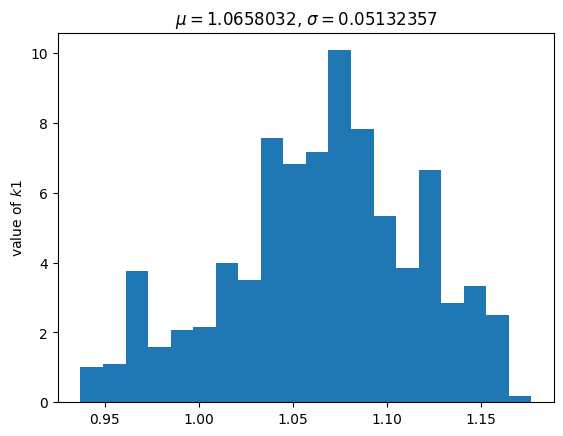

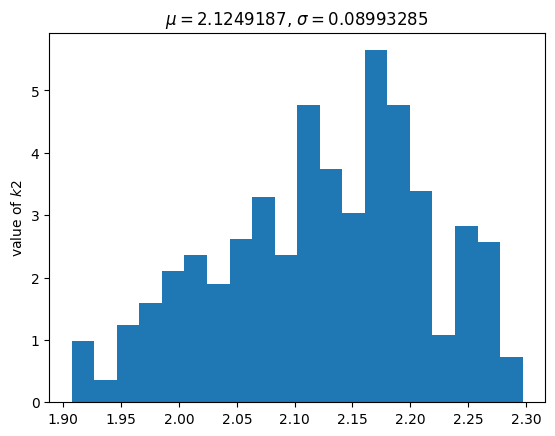

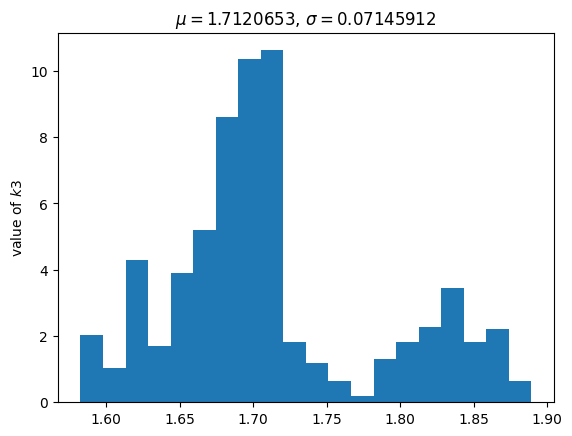

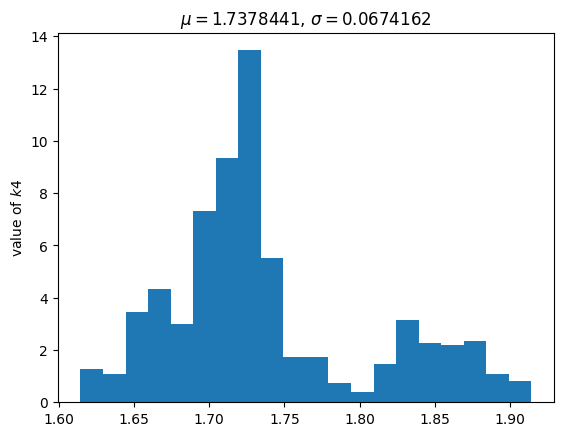

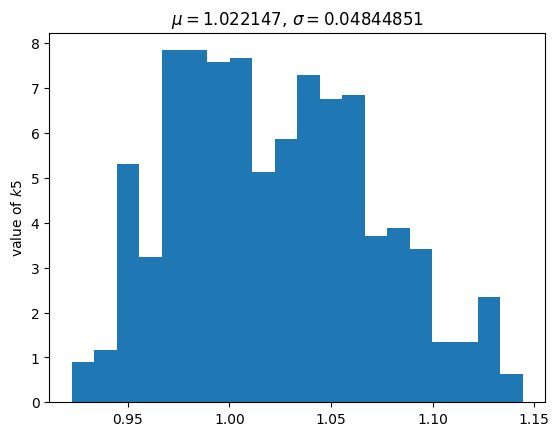

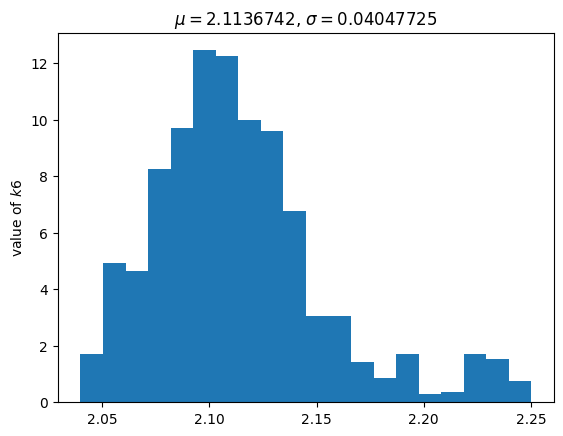

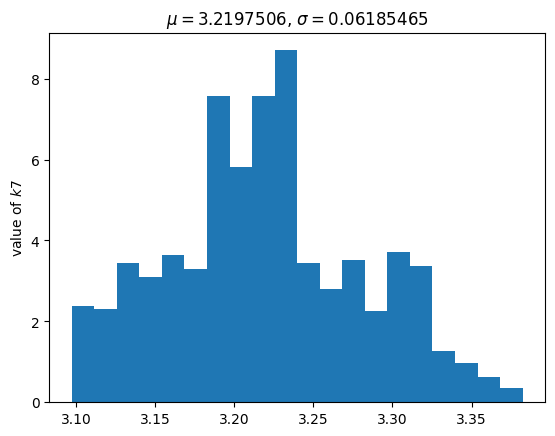

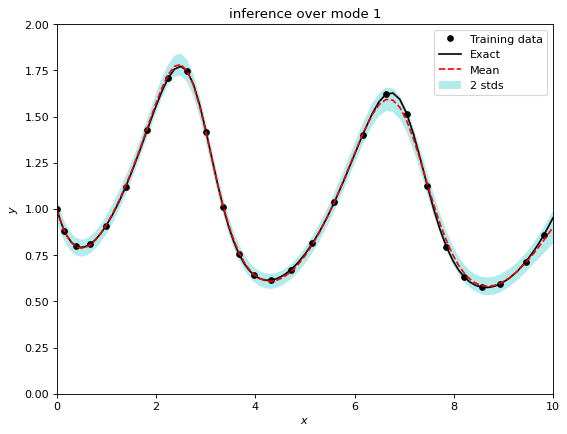

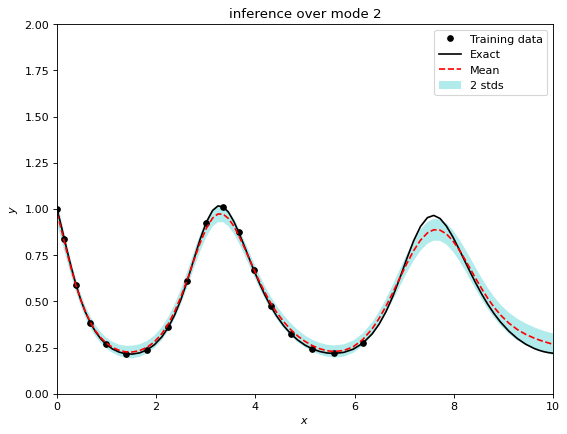

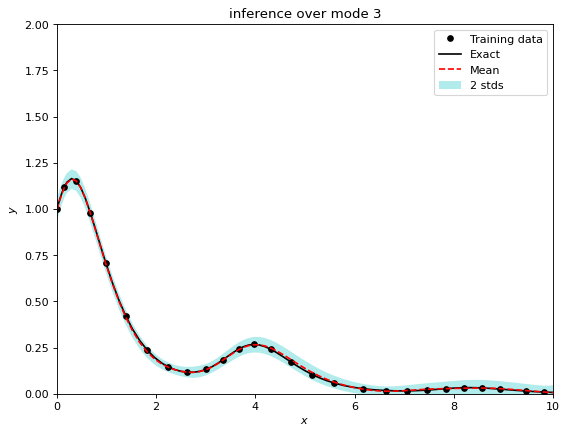

In [26]:
############################### Postprocessing ###################################
plots(u_pred, t_test, u_test, t_u_train, u_train)

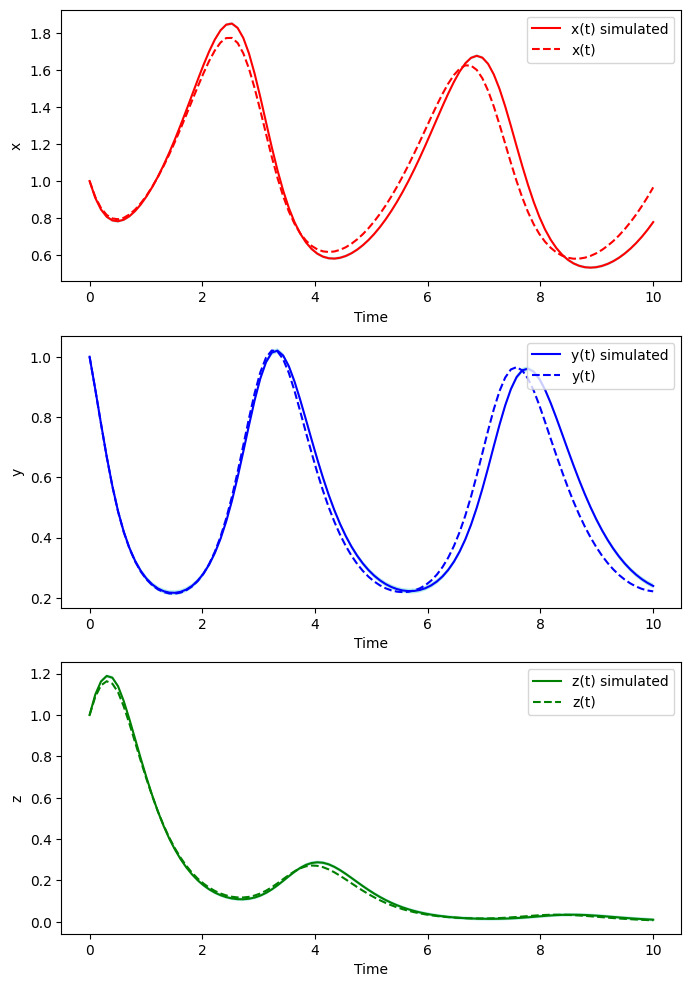

In [28]:
plot_equations2(k1_pred, k2_pred, k3_pred, k4_pred, k5_pred, k6_pred, k7_pred)

## Lotka Volterra [2]

### Functions

In [29]:
def load_data():
    data = sio.loadmat("scripts/lotka_volterra_dataset_2.mat")
    t_test, u_test = data["t_test"], data["u_test"]
    t_u_train, u_train = data["t_u_train"], data["u_train"]
    t_f_train, f_train = data["t_f_train"], data["f_train"]
    noise = 0.05
    return t_u_train, u_train, t_f_train, f_train, noise, t_test, u_test

In [30]:
@neuq.utils.timer
def Samplable(t_u_train, u_train, t_f_train, f_train, noise, layers):  
    u1_train, u3_train = u_train[:, 0:1], u_train[:, 2:3]
    t2_train, u2_train = t_u_train[:25], u_train[:25, 1:2]
    # build processes
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        prior=neuq_vars.fnn.Samplable(layers=layers, mean=0, sigma=1),
    )
    # I build the same process for all the parameters...
    process_k1 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k2 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k3 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k4 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k5 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k6 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k7 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    
    # build likelihood
    likelihood_u13 = neuq.likelihoods.Normal(
        inputs=t_u_train,
        targets=np.concatenate([u1_train, u3_train], axis=-1),
        processes=[process_u],
        out_dims=[[0, 2]],
        sigma=noise,
    )
    likelihood_u2 = neuq.likelihoods.Normal(
        inputs=t2_train,
        targets=u2_train,
        processes=[process_u],
        out_dims=[[1]],
        sigma=noise,
    )
    likelihood_f = neuq.likelihoods.Normal(
        inputs=t_f_train,
        targets=f_train,
        processes=[process_u, process_k1, process_k2, process_k3, process_k4, process_k5, process_k6, process_k7],
        pde=ode_fn,
        sigma=noise,
    )
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_k1, process_k2, process_k3, process_k4, process_k5, process_k6, process_k7],
        likelihoods=[likelihood_u13, likelihood_u2, likelihood_f],
    )
    # assign and compile method
    # Change parameters to make the acceptance rate close to 0.6.
    method = neuq.inferences.HMC(                                         
        num_samples=1000,
        num_burnin=5000,
        init_time_step=0.1,
        leapfrog_step=50,
        seed=777,
    )
    model.compile(method)
    # obtain posterior samples
    samples, results = model.run()
    print("Acceptance rate: %.3f \n"%(np.mean(results)))

    processes = [process_u, process_k1, process_k2, process_k3, process_k4, process_k5, process_k6, process_k7]
    return processes, samples, model

In [31]:
def plots(u_pred, t_test, u_test, t_u_train, u_train):
    u1_pred, u2_pred, u3_pred = np.split(u_pred, 3, axis=-1)
    u1_test, u2_test, u3_test = np.split(u_test, 3, axis=-1)
    u1_train, u3_train = u_train[:, 0:1], u_train[:, 2:3]  # training data
    t2_train, u2_train = t_u_train[:25], u_train[:25, 1:2]  # training data

  # plot parameters' histograms
    neuq.utils.hist(k1_pred, name="value of $k1$")
    neuq.utils.hist(k2_pred, name="value of $k2$")
    neuq.utils.hist(k3_pred, name="value of $k3$")
    neuq.utils.hist(k4_pred, name="value of $k4$")
    neuq.utils.hist(k5_pred, name="value of $k5$")
    neuq.utils.hist(k6_pred, name="value of $k6$")
    neuq.utils.hist(k7_pred, name="value of $k7$")
  
  # plot x1, x2, x3
    neuq.utils.plot1d(
        t_u_train,
        u1_train,
        t_test,
        u1_test,
        u1_pred[..., 0],
        title="inference over mode 1",
        xlim=[0, 10],
        ylim=[0, 2],
    )
    neuq.utils.plot1d(
        t2_train,
        u2_train,
        t_test,
        u2_test,
        u2_pred[..., 0],
        title="inference over mode 2",
        xlim=[0, 10],
        ylim=[0, 2],
    )
    neuq.utils.plot1d(
        t_u_train,
        u3_train,
        t_test,
        u3_test,
        u3_pred[..., 0],
        title="inference over mode 3",
        xlim=[0, 10],
        ylim=[0, 2],
    )

In [33]:
def plot_equations2(k1_pred, k2_pred, k3_pred, k4_pred, k5_pred, k6_pred, k7_pred):
    
    def system(t, vars, a, b, c, d, e, f, g):
        x, y, z = vars
        dxdt = a*x - b*x*y
        dydt = -c*y + d*x*y - e*y*z
        dzdt = -f*z + g*y*z
        return [dxdt, dydt, dzdt]

    # Set the parameters
    a = k1_pred.mean()
    b = k2_pred.mean()
    c = k3_pred.mean()
    d = k4_pred.mean()
    e = k5_pred.mean()
    f = k6_pred.mean()
    g = k7_pred.mean()

    std = max(k1_pred.var(), k2_pred.var(), k3_pred.var(), k4_pred.var(), k5_pred.var(), k6_pred.var(), k7_pred.var())

    # Set the initial conditions
    init_cond = [1, 1, 1]

    # Set the time span
    t_span = [0, 10]
    t_ev = np.linspace(0, 10, 100)

    # Solve the ODEs
    sol = solve_ivp(system, t_span, init_cond, t_eval=t_ev, args=(a, b, c, d, e, f, g))
    solt = solve_ivp(system, t_span, init_cond, t_eval=t_ev, args=(1, 2, 2, 2, 1, 2, 3))

    # Print the solution
    fig, axs = plt.subplots(3, 1, figsize=(8,12))
    axs[0].plot(sol.t, sol.y[0], 'r-', label='x(t) simulated')
    axs[0].plot(solt.t, solt.y[0], 'r--', label='x(t)')
    axs[0].fill_between(sol.t, sol.y[0] - std, sol.y[0] + std, alpha=0.3, facecolor='c')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('x')
    axs[0].legend(loc='upper right')

    axs[1].plot(sol.t, sol.y[1], 'b-', label='y(t) simulated')
    axs[1].plot(solt.t, solt.y[1], 'b--', label='y(t)')
    axs[1].fill_between(sol.t, sol.y[1] - std, sol.y[1] + std, alpha=0.3, facecolor='c')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('y')
    axs[1].legend(loc='upper right')

    axs[2].plot(sol.t, sol.y[2], 'g-', label='z(t) simulated')
    axs[2].plot(solt.t, solt.y[2], 'g--', label='z(t)')
    axs[2].fill_between(sol.t, sol.y[2] - std, sol.y[2] + std, alpha=0.3, facecolor='c')
    axs[2].set_xlabel('Time')
    axs[2].set_ylabel('z')
    axs[2].legend(loc='upper right')

    plt.show()

### Model and predictions

In [34]:
################## Load data and specify some hyperparameters ####################
data = load_data()
t_u_train, u_train, t_f_train, f_train, noise = data[:5]
t_test, u_test = data[5:]
layers = [1, 50, 50, 3]

processes, samples, model = Samplable(
    t_u_train, u_train, t_f_train, f_train, noise, layers
)

Supporting backend tensorflow.compat.v1

Compiling a MCMC method

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

Acceptance rate: 0.411 

Execution time for 'Samplable' function is: 264.929 s, 4.415 mins


In [35]:
################################# Predictions ####################################
u_pred, k1_pred, k2_pred, k3_pred, k4_pred, k5_pred, k6_pred, k7_pred = model.predict(t_test, samples, processes, pde_fn=None)

### Postprocessing

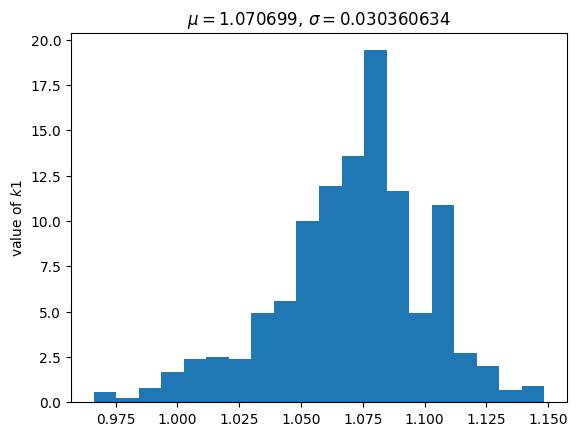

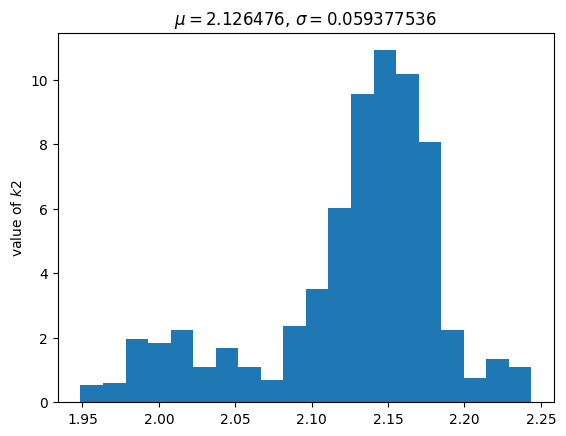

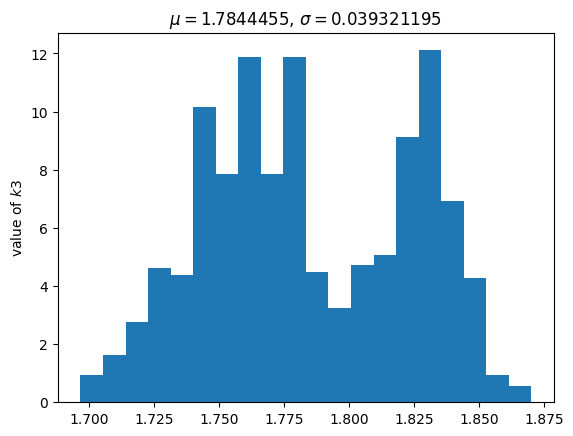

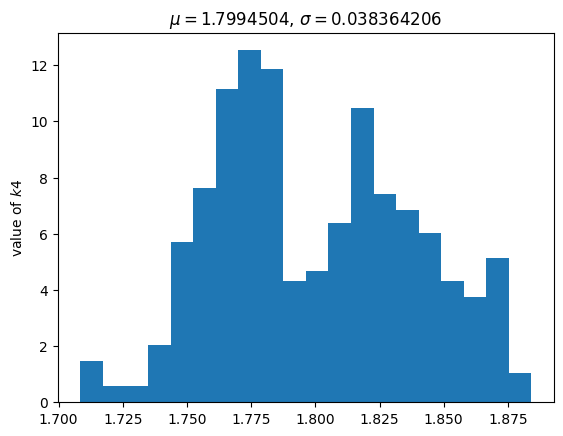

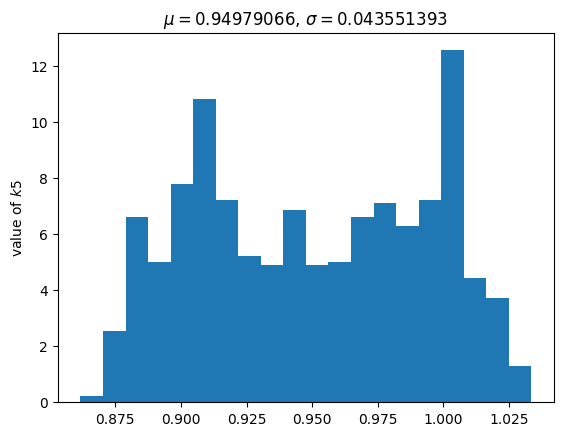

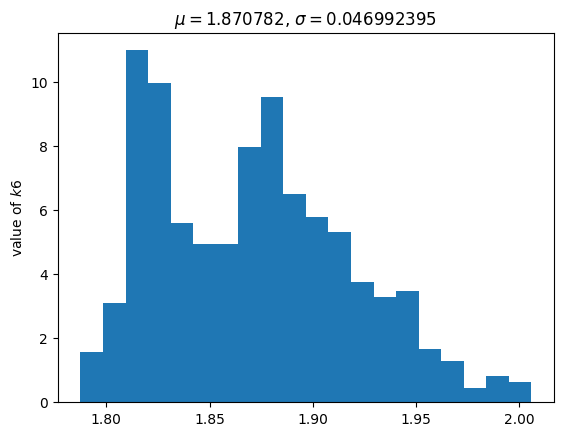

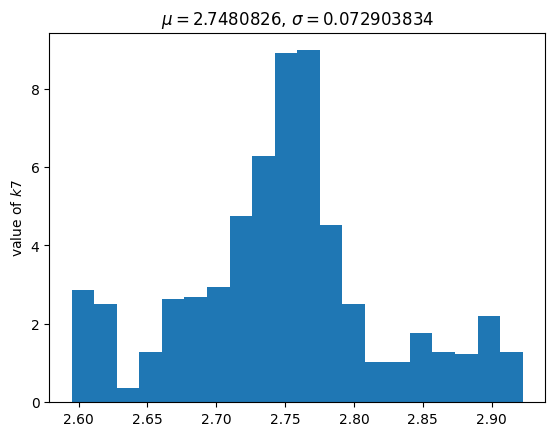

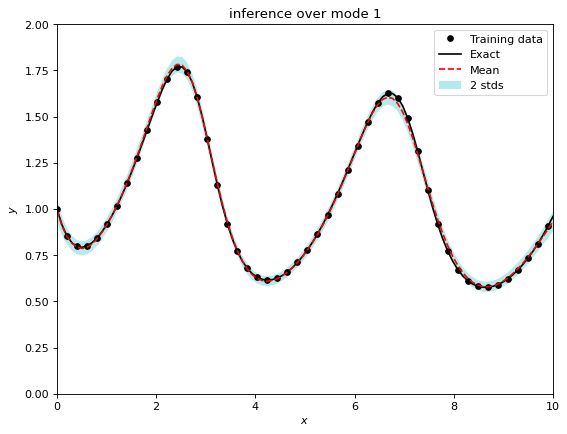

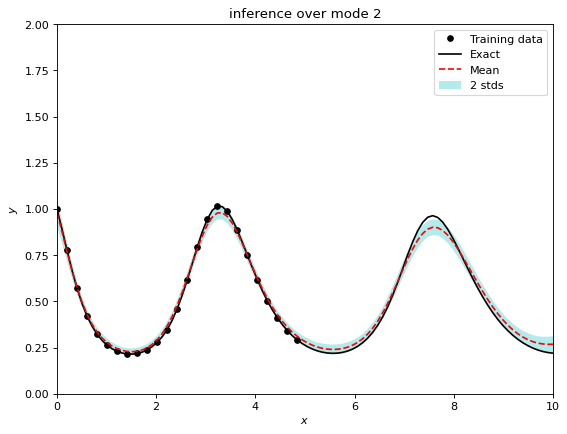

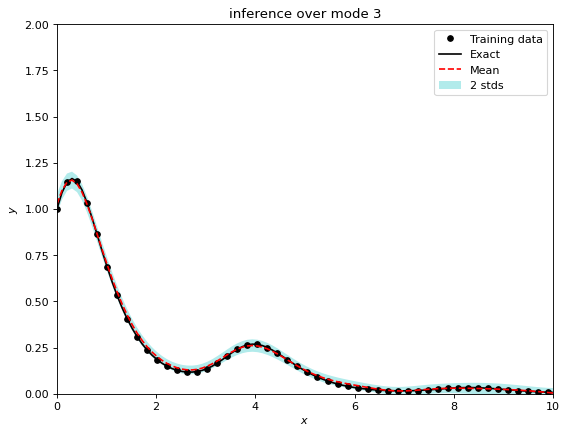

In [36]:
############################### Postprocessing ###################################
plots(u_pred, t_test, u_test, t_u_train, u_train)

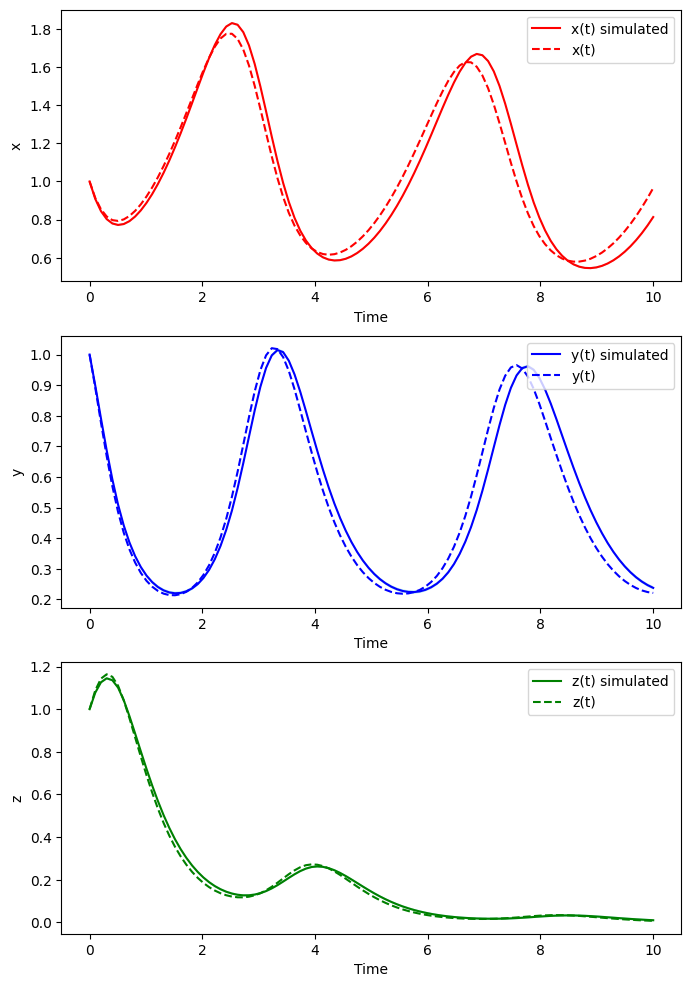

In [38]:
plot_equations2(k1_pred, k2_pred, k3_pred, k4_pred, k5_pred, k6_pred, k7_pred)

## Lotka Volterra [3]
Time interval [0, 20], 47 dati

### Functions

In [4]:
def load_data():
    data = sio.loadmat("scripts/lotka_volterra_dataset_3.mat")
    t_test, u_test = data["t_test"], data["u_test"]
    t_u_train, u_train = data["t_u_train"], data["u_train"]
    t_f_train, f_train = data["t_f_train"], data["f_train"]
    noise = 0.05
    return t_u_train, u_train, t_f_train, f_train, noise, t_test, u_test

In [5]:
@neuq.utils.timer
def Samplable(t_u_train, u_train, t_f_train, f_train, noise, layers):  
    u1_train, u3_train = u_train[:, 0:1], u_train[:, 2:3]
    t2_train, u2_train = t_u_train[:30], u_train[:30, 1:2]
        
    # build processes
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        prior=neuq_vars.fnn.Samplable(layers=layers, mean=0, sigma=1),
    )

    # I build the same process for all the parameters...
    process_k1 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k2 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k3 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k4 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k5 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k6 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k7 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    
    # build likelihood
    likelihood_u13 = neuq.likelihoods.Normal(
        inputs=t_u_train,
        targets=np.concatenate([u1_train, u3_train], axis=-1),
        processes=[process_u],
        out_dims=[[0, 2]],
        sigma=noise,
    )
    likelihood_u2 = neuq.likelihoods.Normal(
        inputs=t2_train,
        targets=u2_train,
        processes=[process_u],
        out_dims=[[1]],
        sigma=noise,
    )
    likelihood_f = neuq.likelihoods.Normal(
        inputs=t_f_train,
        targets=f_train,
        processes=[process_u, process_k1, process_k2, process_k3, process_k4, process_k5, process_k6, process_k7],
        pde=ode_fn,
        sigma=noise,
    )
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_k1, process_k2, process_k3, process_k4, process_k5, process_k6, process_k7],
        likelihoods=[likelihood_u13, likelihood_u2, likelihood_f],
    )
    # assign and compile method
    # Change parameters to make the acceptance rate close to 0.6.
    method = neuq.inferences.HMC(                                         
        num_samples=1000,
        num_burnin=5000,
        init_time_step=0.1,
        leapfrog_step=50,
        seed=777,
    )
    model.compile(method)
    # obtain posterior samples
    samples, results = model.run()
    print("Acceptance rate: %.3f \n"%(np.mean(results)))

    processes = [process_u, process_k1, process_k2, process_k3, process_k4, process_k5, process_k6, process_k7]
    return processes, samples, model


In [6]:
def plots(u_pred, t_test, u_test, t_u_train, u_train):
    u1_pred, u2_pred, u3_pred = np.split(u_pred, 3, axis=-1)
    u1_test, u2_test, u3_test = np.split(u_test, 3, axis=-1)
    u1_train, u3_train = u_train[:, 0:1], u_train[:, 2:3]  # training data
    t2_train, u2_train = t_u_train[:30], u_train[:30, 1:2]  # training data

  # plot parameters' histograms
    neuq.utils.hist(k1_pred, name="value of $k1$")
    neuq.utils.hist(k2_pred, name="value of $k2$")
    neuq.utils.hist(k3_pred, name="value of $k3$")
    neuq.utils.hist(k4_pred, name="value of $k4$")
    neuq.utils.hist(k5_pred, name="value of $k5$")
    neuq.utils.hist(k6_pred, name="value of $k6$")
    neuq.utils.hist(k7_pred, name="value of $k7$")
  
  # plot x1, x2, x3
    neuq.utils.plot1d(
        t_u_train,
        u1_train,
        t_test,
        u1_test,
        u1_pred[..., 0],
        title="inference over mode 1",
        xlim=[0, 20],
        ylim=[0, 2],
    )
    neuq.utils.plot1d(
        t2_train,
        u2_train,
        t_test,
        u2_test,
        u2_pred[..., 0],
        title="inference over mode 2",
        xlim=[0, 20],
        ylim=[0, 2],
    )
    neuq.utils.plot1d(
        t_u_train,
        u3_train,
        t_test,
        u3_test,
        u3_pred[..., 0],
        title="inference over mode 3",
        xlim=[0, 20],
        ylim=[0, 2],
    )

In [8]:
def plot_equations2(k1_pred, k2_pred, k3_pred, k4_pred, k5_pred, k6_pred, k7_pred):
    
    def system(t, vars, a, b, c, d, e, f, g):
        x, y, z = vars
        dxdt = a*x - b*x*y
        dydt = -c*y + d*x*y - e*y*z
        dzdt = -f*z + g*y*z
        return [dxdt, dydt, dzdt]

    # Set the parameters
    a = k1_pred.mean()
    b = k2_pred.mean()
    c = k3_pred.mean()
    d = k4_pred.mean()
    e = k5_pred.mean()
    f = k6_pred.mean()
    g = k7_pred.mean()

    std = max(k1_pred.var(), k2_pred.var(), k3_pred.var(), k4_pred.var(), k5_pred.var(), k6_pred.var(), k7_pred.var())

    # Set the initial conditions
    init_cond = [1, 1, 1]

    # Set the time span
    t_span = [0, 20]
    t_ev = np.linspace(0, 20, 200)

    # Solve the ODEs
    sol = solve_ivp(system, t_span, init_cond, t_eval=t_ev, args=(a, b, c, d, e, f, g))
    solt = solve_ivp(system, t_span, init_cond, t_eval=t_ev, args=(1, 2, 2, 2, 1, 2, 3))

    # Print the solution
    fig, axs = plt.subplots(3, 1, figsize=(8,12))
    axs[0].plot(sol.t, sol.y[0], 'r-', label='x(t) simulated')
    axs[0].plot(solt.t, solt.y[0], 'r--', label='x(t)')
    axs[0].fill_between(sol.t, sol.y[0] - std, sol.y[0] + std, alpha=0.3, facecolor='c')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('x')
    axs[0].legend(loc='upper right')

    axs[1].plot(sol.t, sol.y[1], 'b-', label='y(t) simulated')
    axs[1].plot(solt.t, solt.y[1], 'b--', label='y(t)')
    axs[1].fill_between(sol.t, sol.y[1] - std, sol.y[1] + std, alpha=0.3, facecolor='c')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('y')
    axs[1].legend(loc='upper right')

    axs[2].plot(sol.t, sol.y[2], 'g-', label='z(t) simulated')
    axs[2].plot(solt.t, solt.y[2], 'g--', label='z(t)')
    axs[2].fill_between(sol.t, sol.y[2] - std, sol.y[2] + std, alpha=0.3, facecolor='c')
    axs[2].set_xlabel('Time')
    axs[2].set_ylabel('z')
    axs[2].legend(loc='upper right')

    plt.show()

### Model and predictions

In [9]:
################## Load data and specify some hyperparameters ####################
data = load_data()
t_u_train, u_train, t_f_train, f_train, noise = data[:5]
t_test, u_test = data[5:]
layers = [1, 50, 50, 3]

processes, samples, model = Samplable(
    t_u_train, u_train, t_f_train, f_train, noise, layers
)


2023-03-22 08:55:16.240026: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-22 08:55:16.240076: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ilaria-UX310UQK): /proc/driver/nvidia/version does not exist
2023-03-22 08:55:16.240340: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 08:55:16.242570: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


Supporting backend tensorflow.compat.v1

Compiling a MCMC method

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

Acceptance rate: 0.612 

Execution time for 'Samplable' function is: 357.713 s, 5.962 mins


In [10]:
################################# Predictions ####################################
u_pred, k1_pred, k2_pred, k3_pred, k4_pred, k5_pred, k6_pred, k7_pred = model.predict(t_test, samples, processes, pde_fn=None)

### Post processing

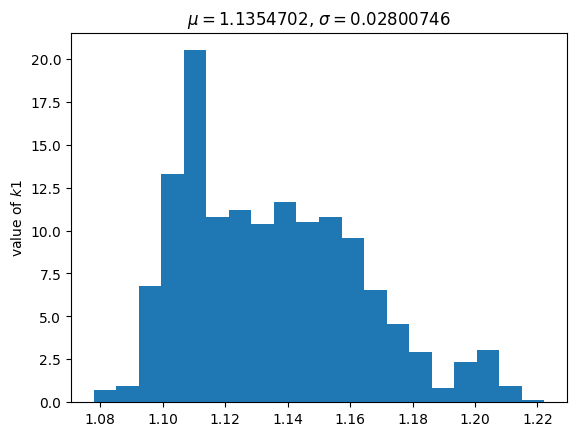

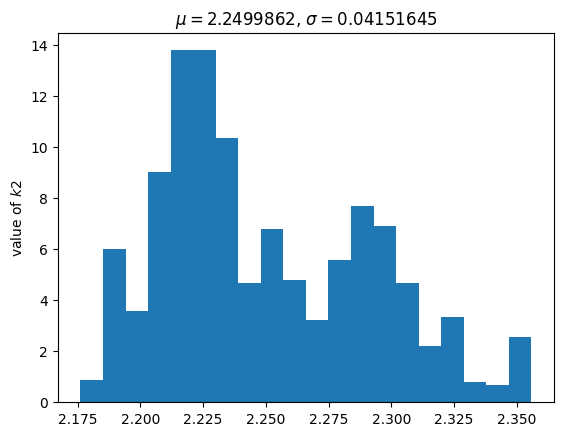

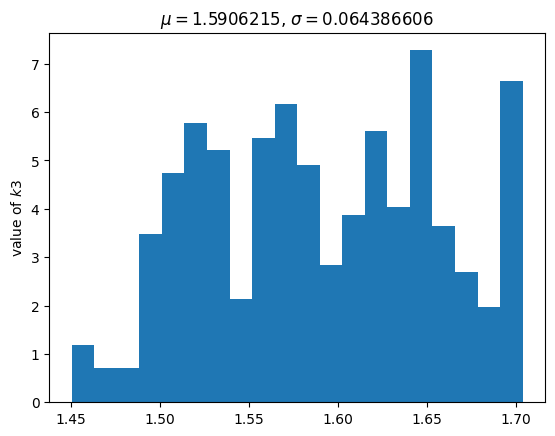

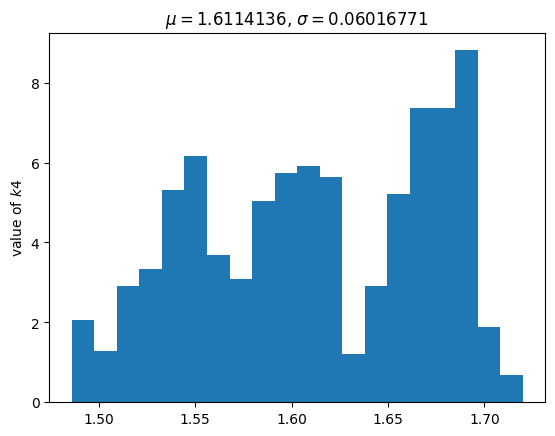

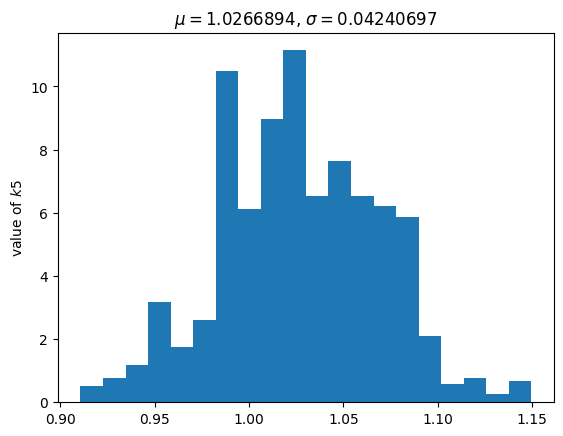

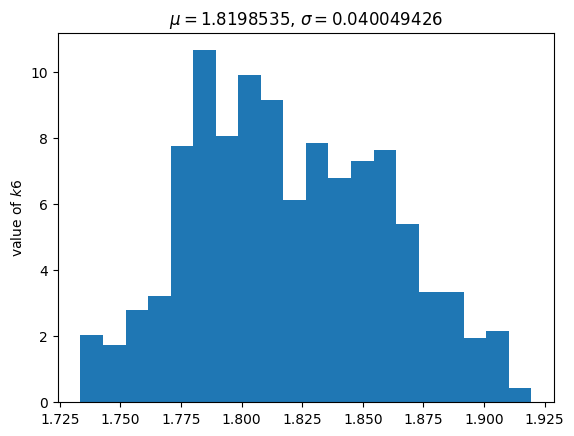

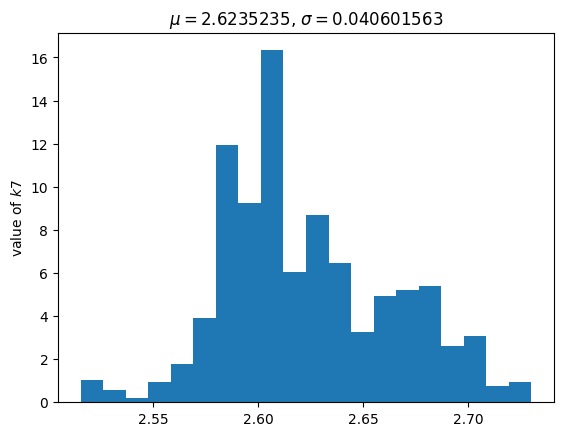

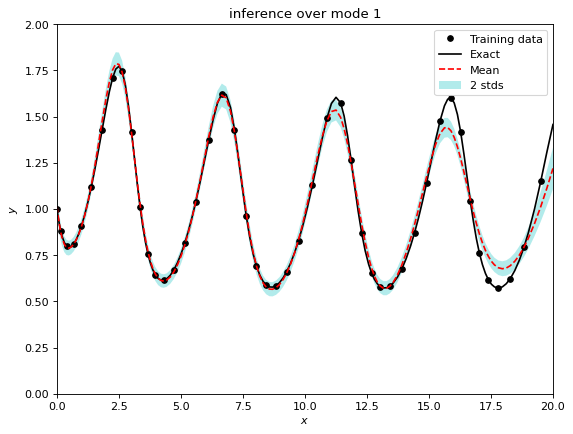

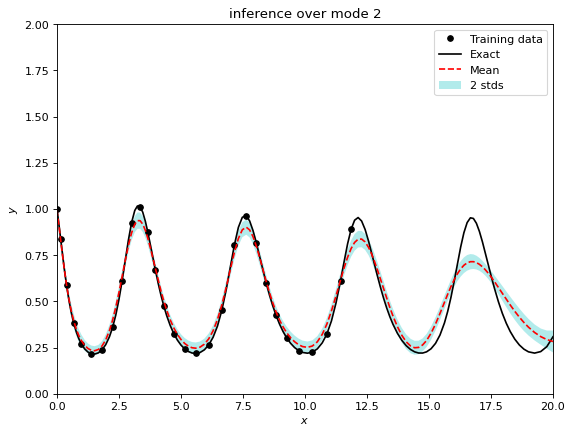

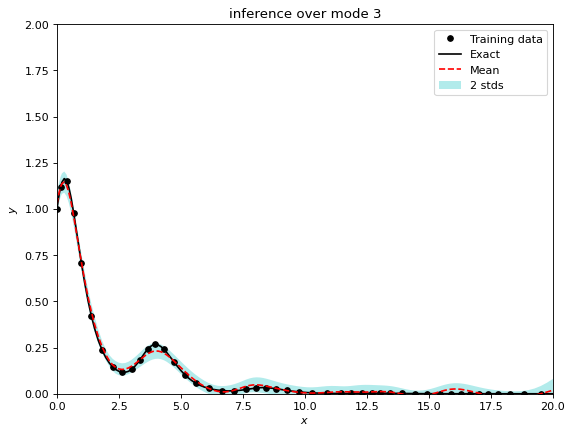

In [11]:
############################### Postprocessing ###################################
plots(u_pred, t_test, u_test, t_u_train, u_train)

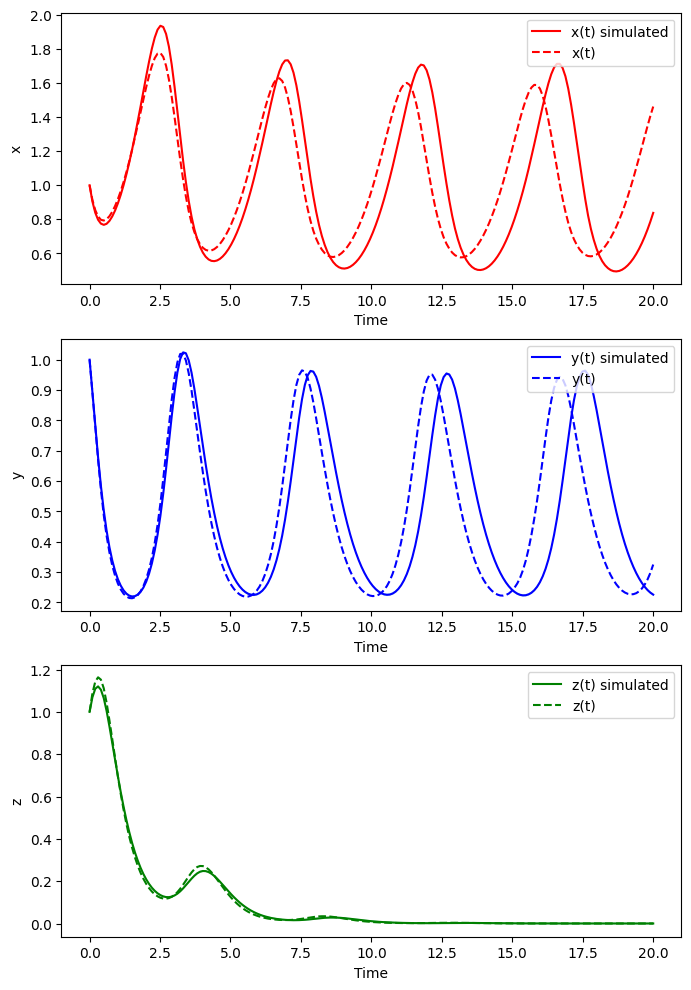

In [13]:
plot_equations2(k1_pred, k2_pred, k3_pred, k4_pred, k5_pred, k6_pred, k7_pred)

## Lotka Volterra [4]
time interval [0, 20] ma con più dati 

### Functions

In [14]:
def load_data():
    data = sio.loadmat("scripts/lotka_volterra_dataset_4.mat")
    t_test, u_test = data["t_test"], data["u_test"]
    t_u_train, u_train = data["t_u_train"], data["u_train"]
    t_f_train, f_train = data["t_f_train"], data["f_train"]
    noise = 0.05
    return t_u_train, u_train, t_f_train, f_train, noise, t_test, u_test

In [15]:
@neuq.utils.timer
def Samplable(t_u_train, u_train, t_f_train, f_train, noise, layers):  
    u1_train, u3_train = u_train[:, 0:1], u_train[:, 2:3]
    t2_train, u2_train = t_u_train[:50], u_train[:50, 1:2]
        
    # build processes
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        prior=neuq_vars.fnn.Samplable(layers=layers, mean=0, sigma=1),
    )

    # I build the same process for all the parameters...
    process_k1 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k2 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k3 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k4 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k5 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k6 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k7 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    
    # build likelihood
    likelihood_u13 = neuq.likelihoods.Normal(
        inputs=t_u_train,
        targets=np.concatenate([u1_train, u3_train], axis=-1),
        processes=[process_u],
        out_dims=[[0, 2]],
        sigma=noise,
    )
    likelihood_u2 = neuq.likelihoods.Normal(
        inputs=t2_train,
        targets=u2_train,
        processes=[process_u],
        out_dims=[[1]],
        sigma=noise,
    )
    likelihood_f = neuq.likelihoods.Normal(
        inputs=t_f_train,
        targets=f_train,
        processes=[process_u, process_k1, process_k2, process_k3, process_k4, process_k5, process_k6, process_k7],
        pde=ode_fn,
        sigma=noise,
    )
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_k1, process_k2, process_k3, process_k4, process_k5, process_k6, process_k7],
        likelihoods=[likelihood_u13, likelihood_u2, likelihood_f],
    )
    # assign and compile method
    # Change parameters to make the acceptance rate close to 0.6.
    method = neuq.inferences.HMC(                                         
        num_samples=1000,
        num_burnin=5000,
        init_time_step=0.1,
        leapfrog_step=50,
        seed=777,
    )
    model.compile(method)
    # obtain posterior samples
    samples, results = model.run()
    print("Acceptance rate: %.3f \n"%(np.mean(results)))

    processes = [process_u, process_k1, process_k2, process_k3, process_k4, process_k5, process_k6, process_k7]
    return processes, samples, model


In [16]:
def plots(u_pred, t_test, u_test, t_u_train, u_train):
    u1_pred, u2_pred, u3_pred = np.split(u_pred, 3, axis=-1)
    u1_test, u2_test, u3_test = np.split(u_test, 3, axis=-1)
    u1_train, u3_train = u_train[:, 0:1], u_train[:, 2:3]  # training data
    t2_train, u2_train = t_u_train[:50], u_train[:50, 1:2]  # training data

  # plot parameters' histograms
    neuq.utils.hist(k1_pred, name="value of $k1$")
    neuq.utils.hist(k2_pred, name="value of $k2$")
    neuq.utils.hist(k3_pred, name="value of $k3$")
    neuq.utils.hist(k4_pred, name="value of $k4$")
    neuq.utils.hist(k5_pred, name="value of $k5$")
    neuq.utils.hist(k6_pred, name="value of $k6$")
    neuq.utils.hist(k7_pred, name="value of $k7$")
  
  # plot x1, x2, x3
    neuq.utils.plot1d(
        t_u_train,
        u1_train,
        t_test,
        u1_test,
        u1_pred[..., 0],
        title="inference over mode 1",
        xlim=[0, 20],
        ylim=[0.4, 2.7],
    )
    neuq.utils.plot1d(
        t2_train,
        u2_train,
        t_test,
        u2_test,
        u2_pred[..., 0],
        title="inference over mode 2",
        xlim=[0, 20],
        ylim=[0, 2.5],
    )
    neuq.utils.plot1d(
        t_u_train,
        u3_train,
        t_test,
        u3_test,
        u3_pred[..., 0],
        title="inference over mode 3",
        xlim=[0, 20],
        ylim=[0, 1.1],
    )

In [18]:
def plot_equations2(k1_pred, k2_pred, k3_pred, k4_pred, k5_pred, k6_pred, k7_pred):
    
    def system(t, vars, a, b, c, d, e, f, g):
        x, y, z = vars
        dxdt = a*x - b*x*y
        dydt = -c*y + d*x*y - e*y*z
        dzdt = -f*z + g*y*z
        return [dxdt, dydt, dzdt]

    # Set the parameters
    a = k1_pred.mean()
    b = k2_pred.mean()
    c = k3_pred.mean()
    d = k4_pred.mean()
    e = k5_pred.mean()
    f = k6_pred.mean()
    g = k7_pred.mean()

    std = max(k1_pred.var(), k2_pred.var(), k3_pred.var(), k4_pred.var(), k5_pred.var(), k6_pred.var(), k7_pred.var())

    # Set the initial conditions
    init_cond = [1, 1, 1]

    # Set the time span
    t_span = [0, 20]
    t_ev = np.linspace(0, 20, 200)

    # Solve the ODEs
    sol = solve_ivp(system, t_span, init_cond, t_eval=t_ev, args=(a, b, c, d, e, f, g))
    solt = solve_ivp(system, t_span, init_cond, t_eval=t_ev, args=(1, 2, 2, 2, 1, 2, 3))

    # Print the solution
    fig, axs = plt.subplots(3, 1, figsize=(8,12))
    axs[0].plot(sol.t, sol.y[0], 'r-', label='x(t) simulated')
    axs[0].plot(solt.t, solt.y[0], 'r--', label='x(t)')
    axs[0].fill_between(sol.t, sol.y[0] - std, sol.y[0] + std, alpha=0.3, facecolor='c')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('x')
    axs[0].legend(loc='upper right')

    axs[1].plot(sol.t, sol.y[1], 'b-', label='y(t) simulated')
    axs[1].plot(solt.t, solt.y[1], 'b--', label='y(t)')
    axs[1].fill_between(sol.t, sol.y[1] - std, sol.y[1] + std, alpha=0.3, facecolor='c')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('y')
    axs[1].legend(loc='upper right')

    axs[2].plot(sol.t, sol.y[2], 'g-', label='z(t) simulated')
    axs[2].plot(solt.t, solt.y[2], 'g--', label='z(t)')
    axs[2].fill_between(sol.t, sol.y[2] - std, sol.y[2] + std, alpha=0.3, facecolor='c')
    axs[2].set_xlabel('Time')
    axs[2].set_ylabel('z')
    axs[2].legend(loc='upper right')

    plt.show()

### Model and predictions

In [19]:
################## Load data and specify some hyperparameters ####################
data = load_data()
t_u_train, u_train, t_f_train, f_train, noise = data[:5]
t_test, u_test = data[5:]
layers = [1, 50, 50, 3]

processes, samples, model = Samplable(
    t_u_train, u_train, t_f_train, f_train, noise, layers
)

Supporting backend tensorflow.compat.v1

Compiling a MCMC method

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

Acceptance rate: 0.395 

Execution time for 'Samplable' function is: 417.834 s, 6.964 mins


In [20]:
################################# Predictions ####################################
u_pred, k1_pred, k2_pred, k3_pred, k4_pred, k5_pred, k6_pred, k7_pred = model.predict(t_test, samples, processes, pde_fn=None)

### Post processing

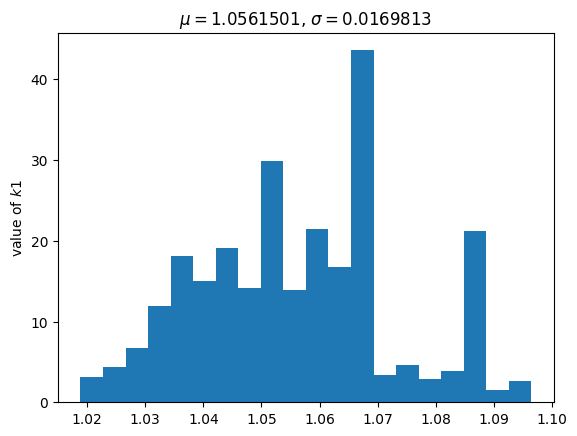

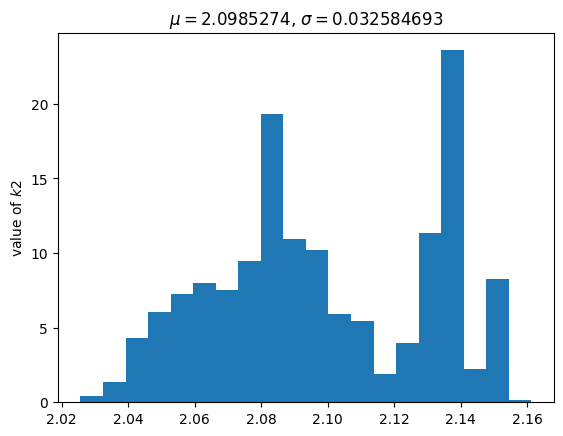

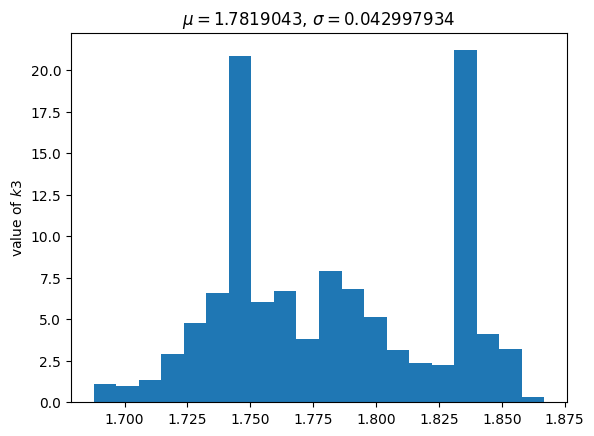

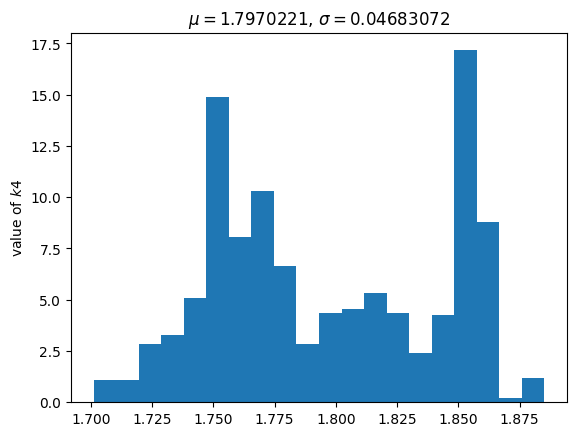

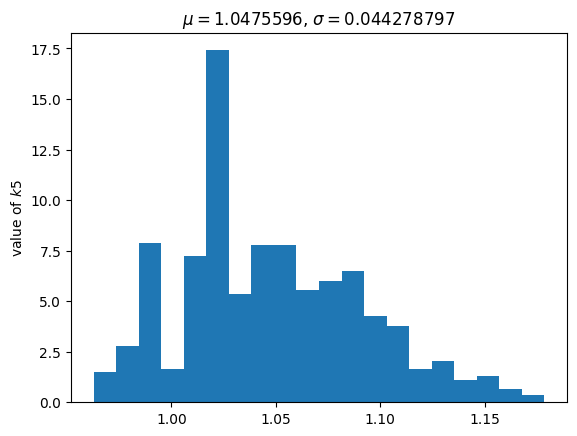

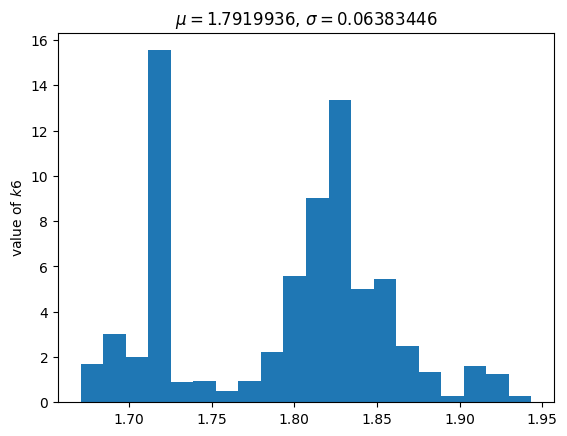

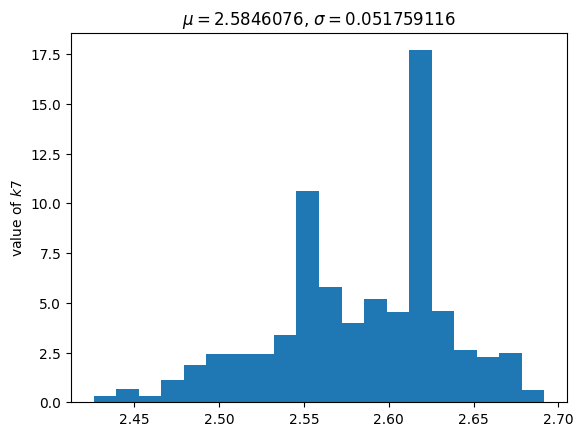

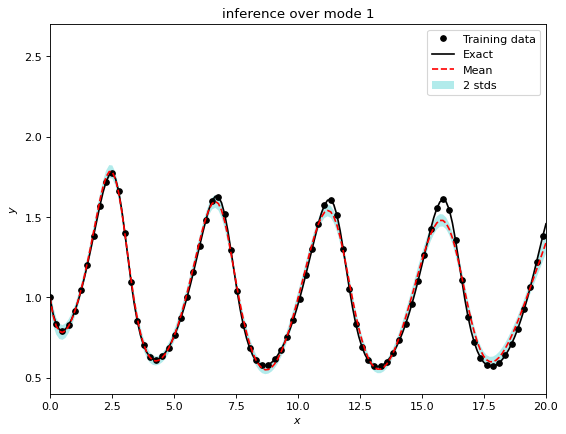

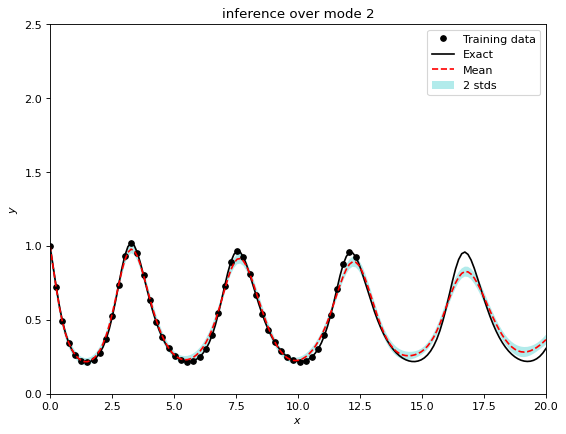

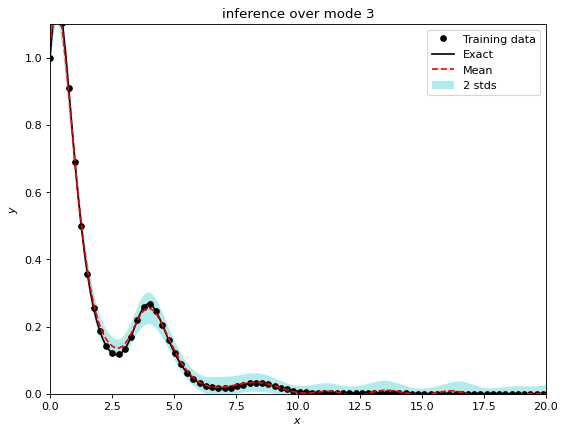

In [21]:
############################### Postprocessing ###################################
plots(u_pred, t_test, u_test, t_u_train, u_train)

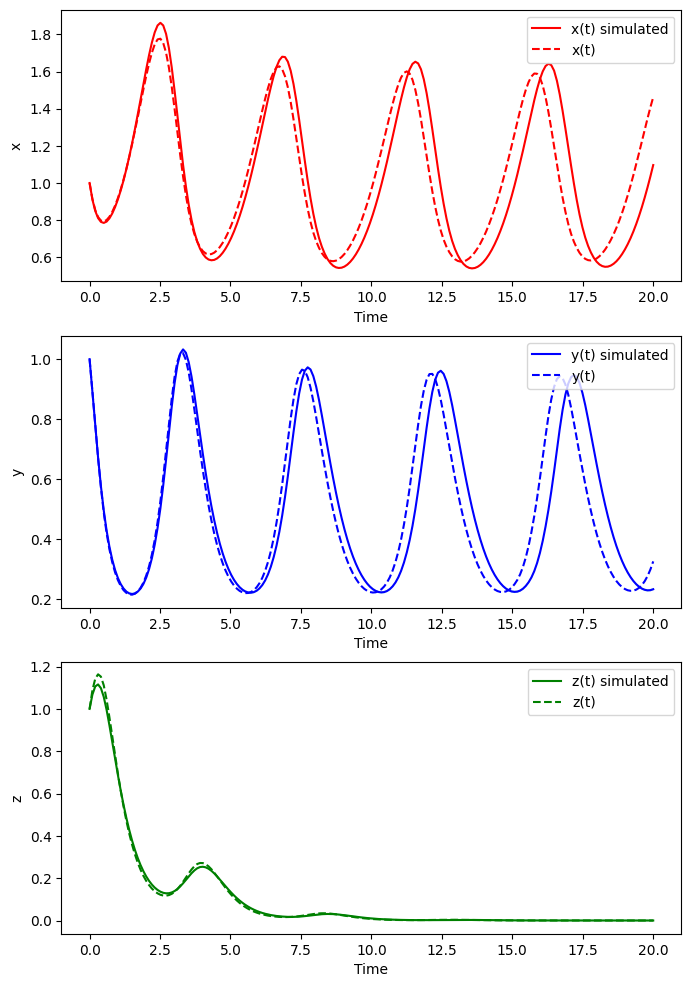

In [23]:
plot_equations2(k1_pred, k2_pred, k3_pred, k4_pred, k5_pred, k6_pred, k7_pred)

## Lotka Volterra [4.5]  
time interval [0, 20] con 50 dati su u_1, u_2, u_3

### Functions

In [24]:
def load_data():
    data = sio.loadmat("scripts/lotka_volterra_dataset_4.mat")
    t_test, u_test = data["t_test"], data["u_test"]
    t_u_train, u_train = data["t_u_train"], data["u_train"]
    t_f_train, f_train = data["t_f_train"], data["f_train"]
    noise = 0.05
    return t_u_train, u_train, t_f_train, f_train, noise, t_test, u_test

In [25]:
@neuq.utils.timer
def Samplable(t_u_train, u_train, t_f_train, f_train, noise, layers):  
    u1_train, u3_train = u_train[:50, 0:1], u_train[:50, 2:3]
    t2_train, u2_train = t_u_train[:50], u_train[:50, 1:2]
        
    # build processes
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        prior=neuq_vars.fnn.Samplable(layers=layers, mean=0, sigma=1),
    )

    # I build the same process for all the parameters...
    process_k1 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k2 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k3 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k4 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k5 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k6 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k7 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    
    # build likelihood
    likelihood_u13 = neuq.likelihoods.Normal(
        inputs=t2_train,
        targets=np.concatenate([u1_train, u3_train], axis=-1),
        processes=[process_u],
        out_dims=[[0, 2]],
        sigma=noise,
    )
    likelihood_u2 = neuq.likelihoods.Normal(
        inputs=t2_train,
        targets=u2_train,
        processes=[process_u],
        out_dims=[[1]],
        sigma=noise,
    )
    likelihood_f = neuq.likelihoods.Normal(
        inputs=t_f_train,
        targets=f_train,
        processes=[process_u, process_k1, process_k2, process_k3, process_k4, process_k5, process_k6, process_k7],
        pde=ode_fn,
        sigma=noise,
    )
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_k1, process_k2, process_k3, process_k4, process_k5, process_k6, process_k7],
        likelihoods=[likelihood_u13, likelihood_u2, likelihood_f],
    )
    # assign and compile method
    # Change parameters to make the acceptance rate close to 0.6.
    method = neuq.inferences.HMC(                                         
        num_samples=1000,
        num_burnin=5000,
        init_time_step=0.1,
        leapfrog_step=50,
        seed=777,
    )
    model.compile(method)
    # obtain posterior samples
    samples, results = model.run()
    print("Acceptance rate: %.3f \n"%(np.mean(results)))

    processes = [process_u, process_k1, process_k2, process_k3, process_k4, process_k5, process_k6, process_k7]
    return processes, samples, model


In [26]:
def plots(u_pred, t_test, u_test, t_u_train, u_train):
    u1_pred, u2_pred, u3_pred = np.split(u_pred, 3, axis=-1)
    u1_test, u2_test, u3_test = np.split(u_test, 3, axis=-1)
    u1_train, u3_train = u_train[:50, 0:1], u_train[:50, 2:3]  # training data
    t2_train, u2_train = t_u_train[:50], u_train[:50, 1:2]  # training data

  # plot parameters' histograms
    neuq.utils.hist(k1_pred, name="value of $k1$")
    neuq.utils.hist(k2_pred, name="value of $k2$")
    neuq.utils.hist(k3_pred, name="value of $k3$")
    neuq.utils.hist(k4_pred, name="value of $k4$")
    neuq.utils.hist(k5_pred, name="value of $k5$")
    neuq.utils.hist(k6_pred, name="value of $k6$")
    neuq.utils.hist(k7_pred, name="value of $k7$")
  
  # plot x1, x2, x3
    neuq.utils.plot1d(
        t2_train,
        u1_train,
        t_test,
        u1_test,
        u1_pred[..., 0],
        title="inference over mode 1",
        xlim=[0, 20],
        ylim=[0, 2],
    )
    neuq.utils.plot1d(
        t2_train,
        u2_train,
        t_test,
        u2_test,
        u2_pred[..., 0],
        title="inference over mode 2",
        xlim=[0, 20],
        ylim=[0, 2],
    )
    neuq.utils.plot1d(
        t2_train,
        u3_train,
        t_test,
        u3_test,
        u3_pred[..., 0],
        title="inference over mode 3",
        xlim=[0, 20],
        ylim=[0, 1],
    )

In [28]:
def plot_equations2(k1_pred, k2_pred, k3_pred, k4_pred, k5_pred, k6_pred, k7_pred):
    
    def system(t, vars, a, b, c, d, e, f, g):
        x, y, z = vars
        dxdt = a*x - b*x*y
        dydt = -c*y + d*x*y - e*y*z
        dzdt = -f*z + g*y*z
        return [dxdt, dydt, dzdt]

    # Set the parameters
    a = k1_pred.mean()
    b = k2_pred.mean()
    c = k3_pred.mean()
    d = k4_pred.mean()
    e = k5_pred.mean()
    f = k6_pred.mean()
    g = k7_pred.mean()

    std = max(k1_pred.var(), k2_pred.var(), k3_pred.var(), k4_pred.var(), k5_pred.var(), k6_pred.var(), k7_pred.var())

    # Set the initial conditions
    init_cond = [1, 1, 1]

    # Set the time span
    t_span = [0, 20]
    t_ev = np.linspace(0, 20, 200)

    # Solve the ODEs
    sol = solve_ivp(system, t_span, init_cond, t_eval=t_ev, args=(a, b, c, d, e, f, g))
    solt = solve_ivp(system, t_span, init_cond, t_eval=t_ev, args=(1, 2, 2, 2, 1, 2, 3))

    # Print the solution
    fig, axs = plt.subplots(3, 1, figsize=(8,12))
    axs[0].plot(sol.t, sol.y[0], 'r-', label='x(t) simulated')
    axs[0].plot(solt.t, solt.y[0], 'r--', label='x(t)')
    axs[0].fill_between(sol.t, sol.y[0] - std, sol.y[0] + std, alpha=0.3, facecolor='c')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('x')
    axs[0].legend(loc='upper right')

    axs[1].plot(sol.t, sol.y[1], 'b-', label='y(t) simulated')
    axs[1].plot(solt.t, solt.y[1], 'b--', label='y(t)')
    axs[1].fill_between(sol.t, sol.y[1] - std, sol.y[1] + std, alpha=0.3, facecolor='c')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('y')
    axs[1].legend(loc='upper right')

    axs[2].plot(sol.t, sol.y[2], 'g-', label='z(t) simulated')
    axs[2].plot(solt.t, solt.y[2], 'g--', label='z(t)')
    axs[2].fill_between(sol.t, sol.y[2] - std, sol.y[2] + std, alpha=0.3, facecolor='c')
    axs[2].set_xlabel('Time')
    axs[2].set_ylabel('z')
    axs[2].legend(loc='upper right')

    plt.show()

### Model and predictions

In [29]:
################## Load data and specify some hyperparameters ####################
data = load_data()
t_u_train, u_train, t_f_train, f_train, noise = data[:5]
t_test, u_test = data[5:]
layers = [1, 50, 50, 3]

processes, samples, model = Samplable(
     t_u_train, u_train, t_f_train, f_train, noise, layers
)

Supporting backend tensorflow.compat.v1

Compiling a MCMC method

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

Acceptance rate: 0.358 

Execution time for 'Samplable' function is: 229.244 s, 3.821 mins


In [30]:
################################# Predictions ####################################
u_pred, k1_pred, k2_pred, k3_pred, k4_pred, k5_pred, k6_pred, k7_pred = model.predict(t_test, samples, processes, pde_fn=None)

### Post processing

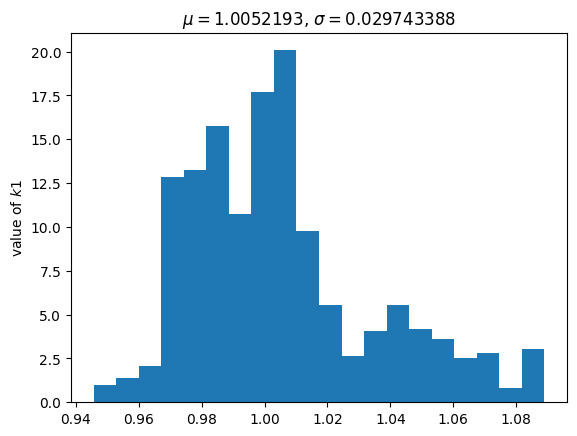

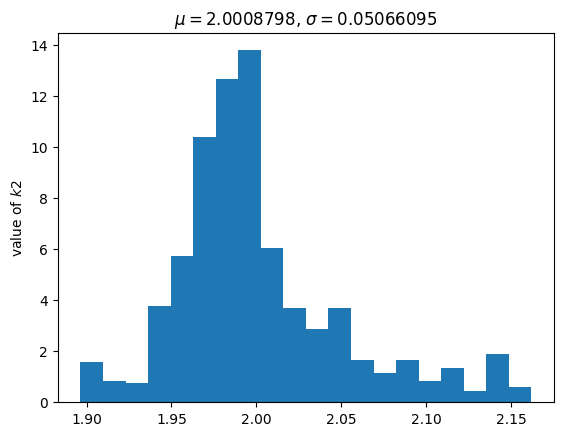

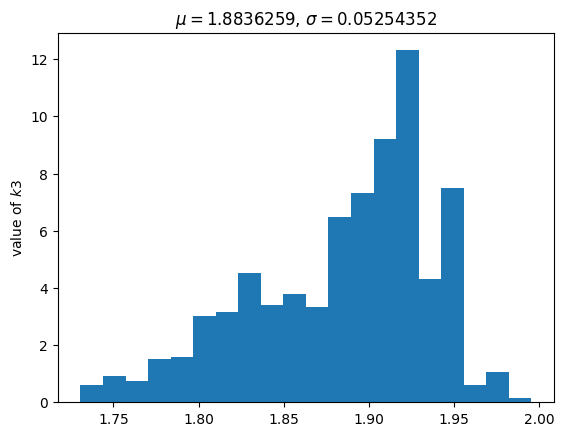

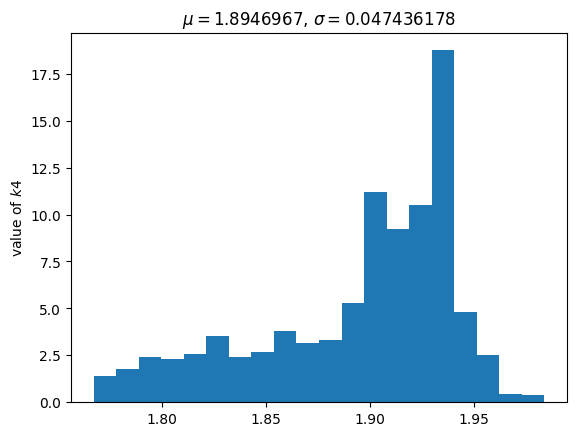

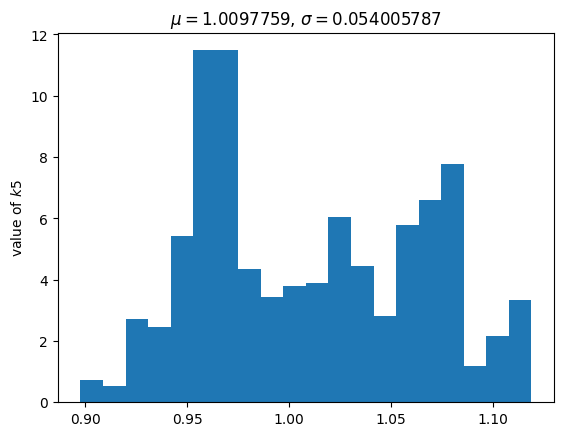

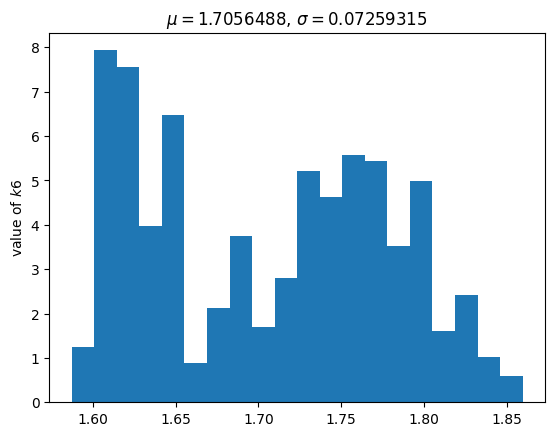

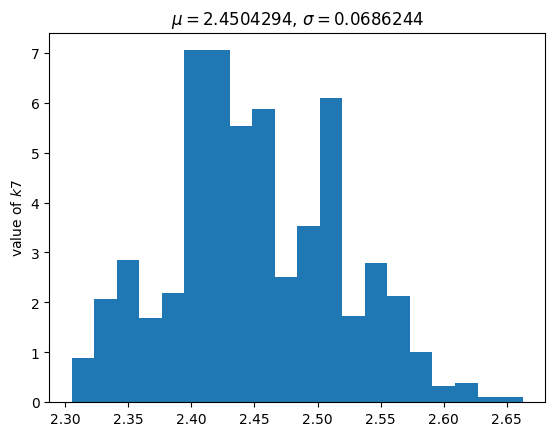

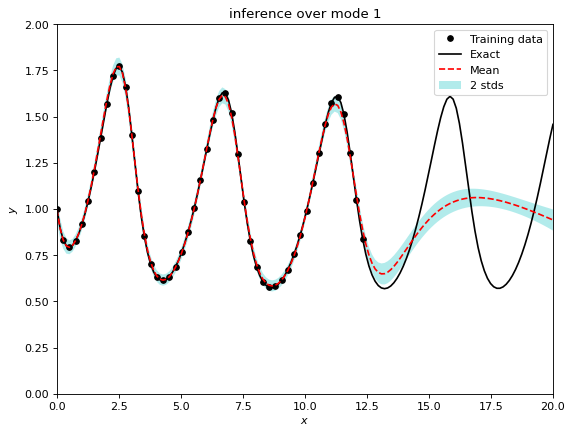

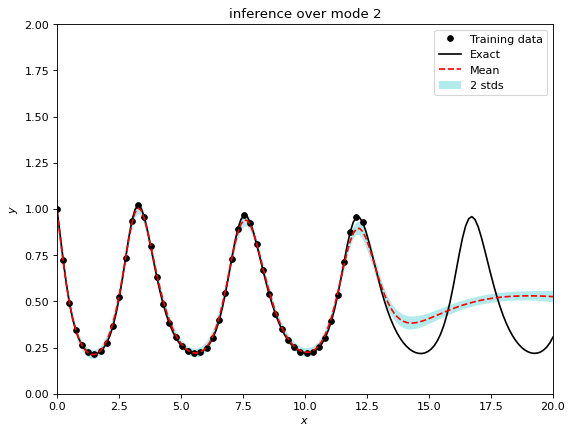

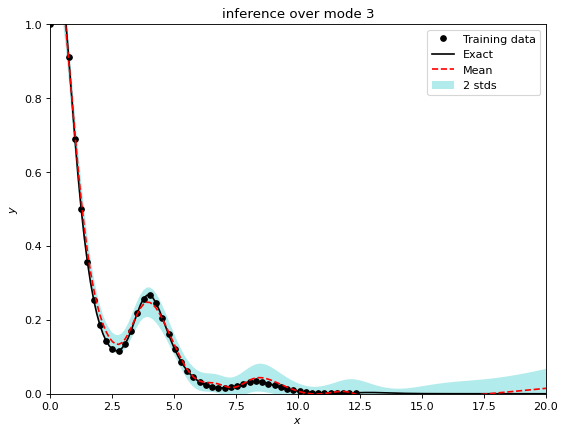

In [31]:
############################### Postprocessing ###################################
plots(u_pred, t_test, u_test, t_u_train, u_train)

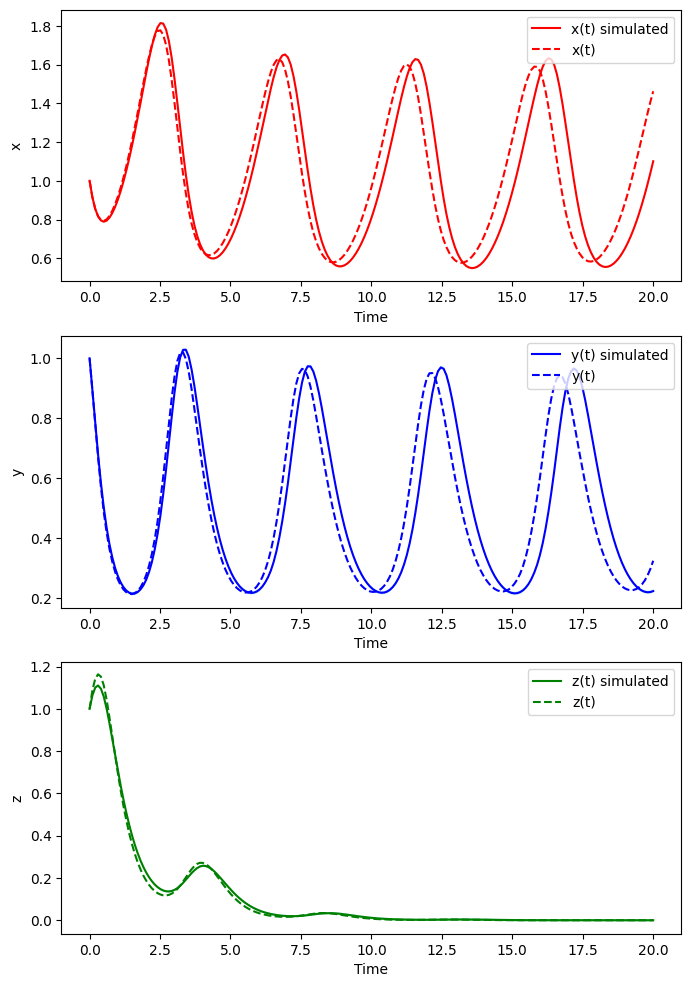

In [33]:
plot_equations2(k1_pred, k2_pred, k3_pred, k4_pred, k5_pred, k6_pred, k7_pred)

## Lotka Volterra [5]
time interval [0, 30] 

### Functions

In [57]:
def load_data():
    data = sio.loadmat("scripts/lotka_volterra_dataset_5.mat")
    t_test, u_test = data["t_test"], data["u_test"]
    t_u_train, u_train = data["t_u_train"], data["u_train"]
    t_f_train, f_train = data["t_f_train"], data["f_train"]
    noise = 0.05
    return t_u_train, u_train, t_f_train, f_train, noise, t_test, u_test

In [58]:
@neuq.utils.timer
def Samplable(t_u_train, u_train, t_f_train, f_train, noise, layers):  
    u1_train, u3_train = u_train[:, 0:1], u_train[:, 2:3]
    t13_train = t_u_train[:30]
    t2_train, u2_train = t_u_train[:30], u_train[:30, 1:2]
        
    # build processes
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        prior=neuq_vars.fnn.Samplable(layers=layers, mean=0, sigma=1),
    )

    # I build the same process for all the parameters...
    process_k1 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k2 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k3 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k4 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k5 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k6 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k7 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    
    # build likelihood
    likelihood_u13 = neuq.likelihoods.Normal(
        inputs=t_u_train,
        targets=np.concatenate([u1_train, u3_train], axis=-1),
        processes=[process_u],
        out_dims=[[0, 2]],
        sigma=noise,
    )
    likelihood_u2 = neuq.likelihoods.Normal(
        inputs=t2_train,
        targets=u2_train,
        processes=[process_u],
        out_dims=[[1]],
        sigma=noise,
    )
    likelihood_f = neuq.likelihoods.Normal(
        inputs=t_f_train,
        targets=f_train,
        processes=[process_u, process_k1, process_k2, process_k3, process_k4, process_k5, process_k6, process_k7],
        pde=ode_fn,
        sigma=noise,
    )
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_k1, process_k2, process_k3, process_k4, process_k5, process_k6, process_k7],
        likelihoods=[likelihood_u13, likelihood_u2, likelihood_f],
    )
    # assign and compile method
    # Change parameters to make the acceptance rate close to 0.6.
    method = neuq.inferences.HMC(                                         
        num_samples=1000,
        num_burnin=5000,
        init_time_step=0.1,
        leapfrog_step=50,
        seed=777,
    )
    model.compile(method)
    # obtain posterior samples
    samples, results = model.run()
    print("Acceptance rate: %.3f \n"%(np.mean(results)))

    processes = [process_u, process_k1, process_k2, process_k3, process_k4, process_k5, process_k6, process_k7]
    return processes, samples, model


In [65]:
def plots(u_pred, t_test, u_test, t_u_train, u_train):
    u1_pred, u2_pred, u3_pred = np.split(u_pred, 3, axis=-1)
    u1_test, u2_test, u3_test = np.split(u_test, 3, axis=-1)
    u1_train, u3_train = u_train[:, 0:1], u_train[:, 2:3]  # training data
    t2_train, u2_train = t_u_train[:30], u_train[:30, 1:2]  # training data  

  # plot parameters' histograms
    neuq.utils.hist(k1_pred, name="value of $k1$")
    neuq.utils.hist(k2_pred, name="value of $k2$")
    neuq.utils.hist(k3_pred, name="value of $k3$")
    neuq.utils.hist(k4_pred, name="value of $k4$")
    neuq.utils.hist(k5_pred, name="value of $k5$")
    neuq.utils.hist(k6_pred, name="value of $k6$")
    neuq.utils.hist(k7_pred, name="value of $k7$")
  
  # plot x1, x2, x3
    neuq.utils.plot1d(
        t_u_train,
        u1_train,
        t_test,
        u1_test,
        u1_pred[..., 0],
        title="inference over mode 1",
        xlim=[0, 30],
        ylim=[0, 2],
    )
    neuq.utils.plot1d(
        t2_train,
        u2_train,
        t_test,
        u2_test,
        u2_pred[..., 0],
        title="inference over mode 2",
        xlim=[0, 30],
        ylim=[0, 2],
    )
    neuq.utils.plot1d(
        t_u_train,
        u3_train,
        t_test,
        u3_test,
        u3_pred[..., 0],
        title="inference over mode 3",
        xlim=[0, 30],
        ylim=[0, 1],
    )

In [60]:
def plot_equations2(k1_pred, k2_pred, k3_pred, k4_pred, k5_pred, k6_pred, k7_pred):
    
    def system(t, vars, a, b, c, d, e, f, g):
        x, y, z = vars
        dxdt = a*x - b*x*y
        dydt = -c*y + d*x*y - e*y*z
        dzdt = -f*z + g*y*z
        return [dxdt, dydt, dzdt]

    # Set the parameters
    a = k1_pred.mean()
    b = k2_pred.mean()
    c = k3_pred.mean()
    d = k4_pred.mean()
    e = k5_pred.mean()
    f = k6_pred.mean()
    g = k7_pred.mean()

    std = max(k1_pred.var(), k2_pred.var(), k3_pred.var(), k4_pred.var(), k5_pred.var(), k6_pred.var(), k7_pred.var())

    # Set the initial conditions
    init_cond = [1, 1, 1]

    # Set the time span
    t_span = [0, 30]
    t_ev = np.linspace(0, 30, 300)

    # Solve the ODEs
    sol = solve_ivp(system, t_span, init_cond, t_eval=t_ev, args=(a, b, c, d, e, f, g))
    solt = solve_ivp(system, t_span, init_cond, t_eval=t_ev, args=(1, 2, 2, 2, 1, 2, 3))

    # Print the solution
    fig, axs = plt.subplots(3, 1, figsize=(8,12))
    axs[0].plot(sol.t, sol.y[0], 'r-', label='x(t) simulated')
    axs[0].plot(solt.t, solt.y[0], 'r--', label='x(t)')
    axs[0].fill_between(sol.t, sol.y[0] - std, sol.y[0] + std, alpha=0.3, facecolor='c')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('x')
    axs[0].legend(loc='upper right')

    axs[1].plot(sol.t, sol.y[1], 'b-', label='y(t) simulated')
    axs[1].plot(solt.t, solt.y[1], 'b--', label='y(t)')
    axs[1].fill_between(sol.t, sol.y[1] - std, sol.y[1] + std, alpha=0.3, facecolor='c')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('y')
    axs[1].legend(loc='upper right')

    axs[2].plot(sol.t, sol.y[2], 'g-', label='z(t) simulated')
    axs[2].plot(solt.t, solt.y[2], 'g--', label='z(t)')
    axs[2].fill_between(sol.t, sol.y[2] - std, sol.y[2] + std, alpha=0.3, facecolor='c')
    axs[2].set_xlabel('Time')
    axs[2].set_ylabel('z')
    axs[2].legend(loc='upper right')

    plt.show()

### Model and predictions

In [61]:
################## Load data and specify some hyperparameters ####################
data = load_data()
t_u_train, u_train, t_f_train, f_train, noise = data[:5]
t_test, u_test = data[5:]
layers = [1, 50, 50, 3]

processes, samples, model = Samplable(
     t_u_train, u_train, t_f_train, f_train, noise, layers
)

Supporting backend tensorflow.compat.v1

Compiling a MCMC method

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

Acceptance rate: 0.344 

Execution time for 'Samplable' function is: 243.120 s, 4.052 mins


In [62]:
################################# Predictions ####################################
u_pred, k1_pred, k2_pred, k3_pred, k4_pred, k5_pred, k6_pred, k7_pred = model.predict(t_test, samples, processes, pde_fn=None)

### Post processing

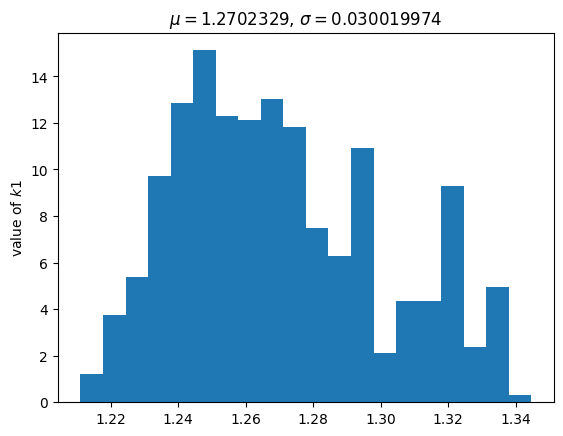

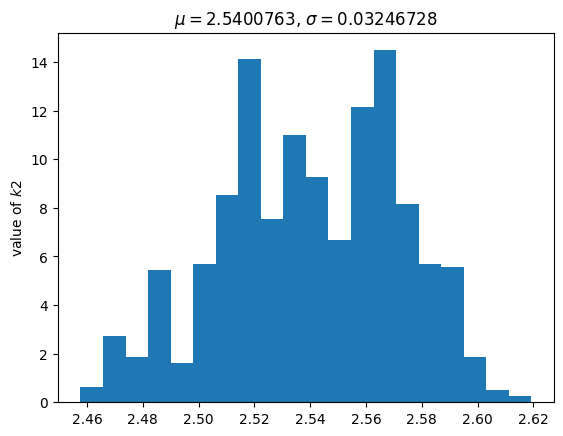

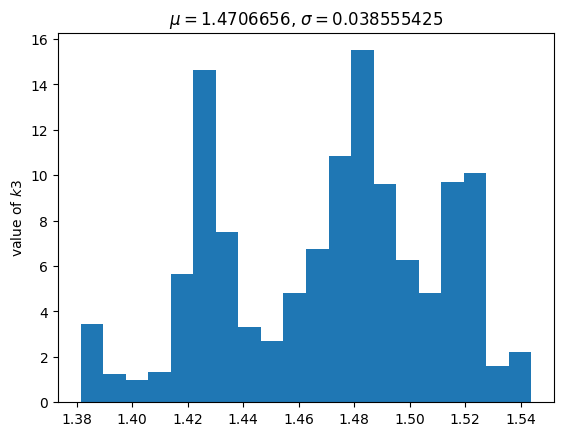

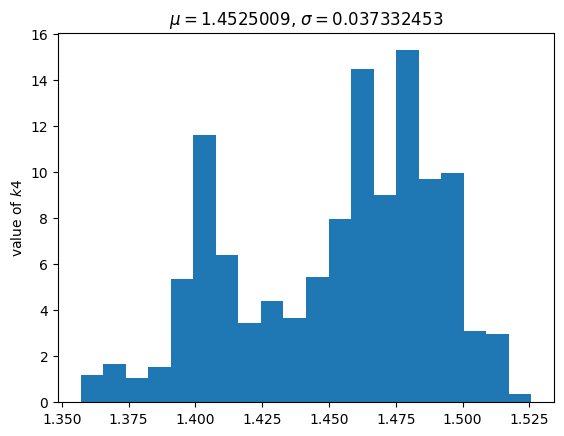

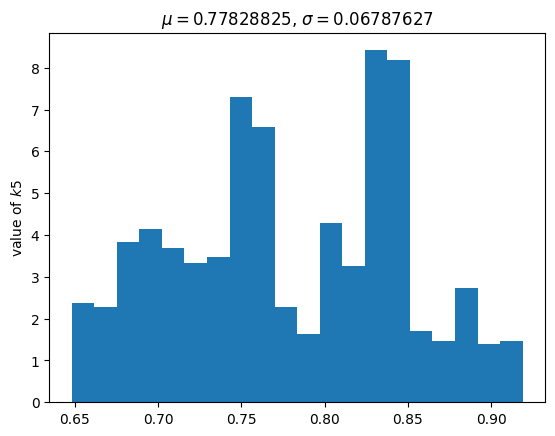

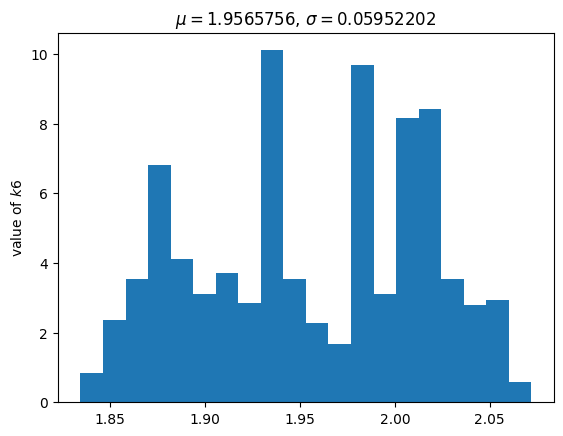

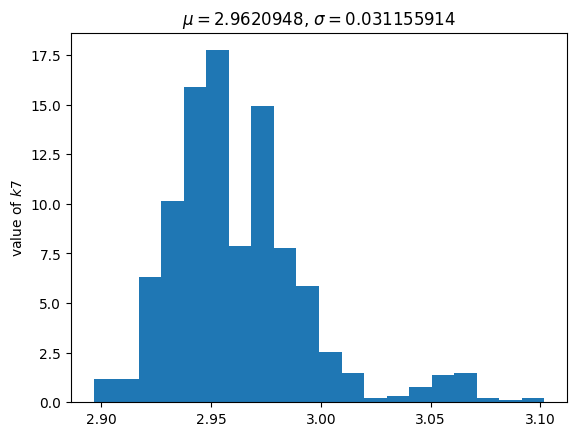

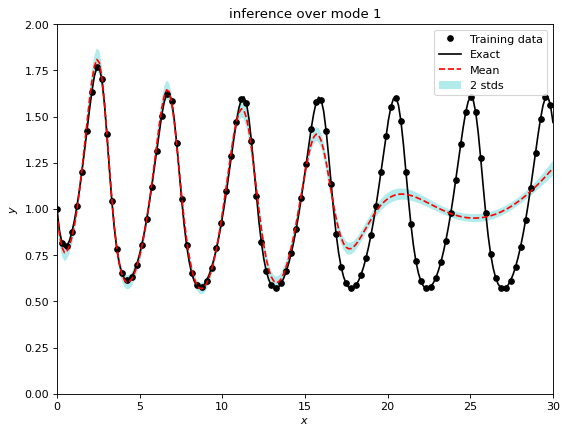

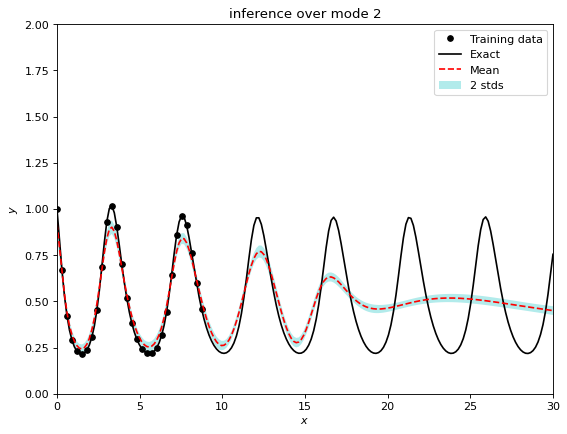

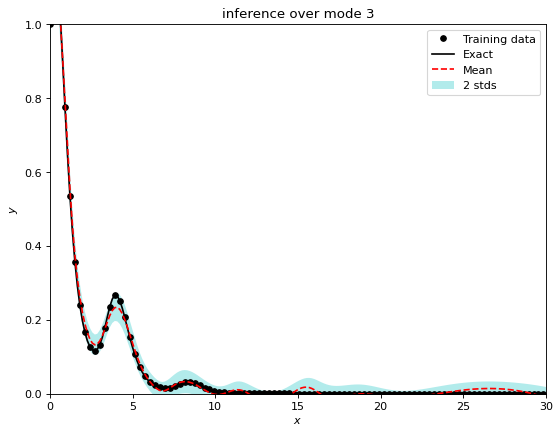

In [66]:
############################### Postprocessing ###################################
plots(u_pred, t_test, u_test, t_u_train, u_train)

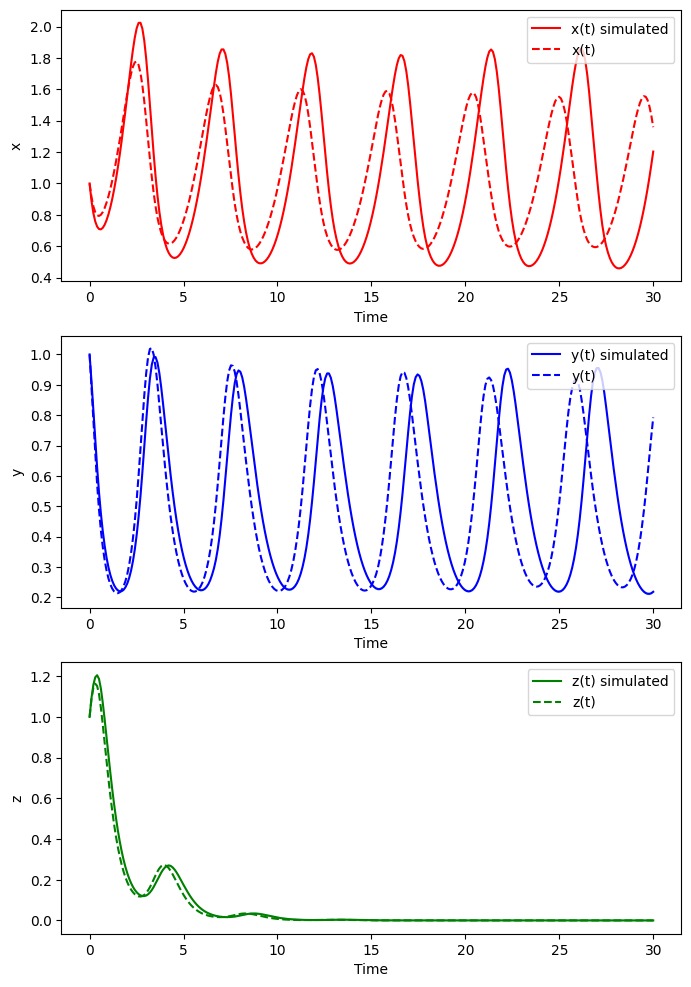

In [64]:
plot_equations2(k1_pred, k2_pred, k3_pred, k4_pred, k5_pred, k6_pred, k7_pred)

## Lotka Volterra [5.5]
time interval [0, 30] con 75 dati su u_1, u_3 e 40 dati su u_2

### Functions

In [40]:
def load_data():
    data = sio.loadmat("scripts/lotka_volterra_dataset_5.mat")
    t_test, u_test = data["t_test"], data["u_test"]
    t_u_train, u_train = data["t_u_train"], data["u_train"]
    t_f_train, f_train = data["t_f_train"], data["f_train"]
    noise = 0.05
    return t_u_train, u_train, t_f_train, f_train, noise, t_test, u_test

In [41]:
@neuq.utils.timer
def Samplable(t_u_train, u_train, t_f_train, f_train, noise, layers):  
    u1_train, u3_train = u_train[:75, 0:1], u_train[:75, 2:3]
    t13_train = t_u_train[:75]
    t2_train, u2_train = t_u_train[:40], u_train[:40, 1:2]
        
    # build processes
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        prior=neuq_vars.fnn.Samplable(layers=layers, mean=0, sigma=1),
    )

    # I build the same process for all the parameters...
    process_k1 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k2 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k3 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k4 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k5 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k6 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k7 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    
    # build likelihood
    likelihood_u13 = neuq.likelihoods.Normal(
        inputs=t13_train, #t_u_train,
        targets=np.concatenate([u1_train, u3_train], axis=-1),
        processes=[process_u],
        out_dims=[[0, 2]],
        sigma=noise,
    )
    likelihood_u2 = neuq.likelihoods.Normal(
        inputs=t2_train,
        targets=u2_train,
        processes=[process_u],
        out_dims=[[1]],
        sigma=noise,
    )
    likelihood_f = neuq.likelihoods.Normal(
        inputs=t_f_train,
        targets=f_train,
        processes=[process_u, process_k1, process_k2, process_k3, process_k4, process_k5, process_k6, process_k7],
        pde=ode_fn,
        sigma=noise,
    )
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_k1, process_k2, process_k3, process_k4, process_k5, process_k6, process_k7],
        likelihoods=[likelihood_u13, likelihood_u2, likelihood_f],
    )
    # assign and compile method
    # Change parameters to make the acceptance rate close to 0.6.
    method = neuq.inferences.HMC(                                         
        num_samples=1000,
        num_burnin=5000,
        init_time_step=0.1,
        leapfrog_step=50,
        seed=777,
    )
    model.compile(method)
    # obtain posterior samples
    samples, results = model.run()
    print("Acceptance rate: %.3f \n"%(np.mean(results)))

    processes = [process_u, process_k1, process_k2, process_k3, process_k4, process_k5, process_k6, process_k7]
    return processes, samples, model


In [42]:
def plots(u_pred, t_test, u_test, t_u_train, u_train):
    u1_pred, u2_pred, u3_pred = np.split(u_pred, 3, axis=-1)
    u1_test, u2_test, u3_test = np.split(u_test, 3, axis=-1)
    u1_train, u3_train = u_train[:75, 0:1], u_train[:75, 2:3]  # training data
    t13_train = t_u_train[:75]
    t2_train, u2_train = t_u_train[:40], u_train[:40, 1:2]  # training data  

  # plot parameters' histograms
    neuq.utils.hist(k1_pred, name="value of $k1$")
    neuq.utils.hist(k2_pred, name="value of $k2$")
    neuq.utils.hist(k3_pred, name="value of $k3$")
    neuq.utils.hist(k4_pred, name="value of $k4$")
    neuq.utils.hist(k5_pred, name="value of $k5$")
    neuq.utils.hist(k6_pred, name="value of $k6$")
    neuq.utils.hist(k7_pred, name="value of $k7$")
  
  # plot x1, x2, x3
    neuq.utils.plot1d(
        t13_train,
        u1_train,
        t_test,
        u1_test,
        u1_pred[..., 0],
        title="inference over mode 1",
        xlim=[0, 30],
        ylim=[0, 2],
    )
    neuq.utils.plot1d(
        t2_train,
        u2_train,
        t_test,
        u2_test,
        u2_pred[..., 0],
        title="inference over mode 2",
        xlim=[0, 30],
        ylim=[0, 2],
    )
    neuq.utils.plot1d(
        t13_train,
        u3_train,
        t_test,
        u3_test,
        u3_pred[..., 0],
        title="inference over mode 3",
        xlim=[0, 30],
        ylim=[0, 1],
    )

In [44]:
def plot_equations2(k1_pred, k2_pred, k3_pred, k4_pred, k5_pred, k6_pred, k7_pred):
    
    def system(t, vars, a, b, c, d, e, f, g):
        x, y, z = vars
        dxdt = a*x - b*x*y
        dydt = -c*y + d*x*y - e*y*z
        dzdt = -f*z + g*y*z
        return [dxdt, dydt, dzdt]

    # Set the parameters
    a = k1_pred.mean()
    b = k2_pred.mean()
    c = k3_pred.mean()
    d = k4_pred.mean()
    e = k5_pred.mean()
    f = k6_pred.mean()
    g = k7_pred.mean()

    std = max(k1_pred.var(), k2_pred.var(), k3_pred.var(), k4_pred.var(), k5_pred.var(), k6_pred.var(), k7_pred.var())

    # Set the initial conditions
    init_cond = [1, 1, 1]

    # Set the time span
    t_span = [0, 30]
    t_ev = np.linspace(0, 30, 300)

    # Solve the ODEs
    sol = solve_ivp(system, t_span, init_cond, t_eval=t_ev, args=(a, b, c, d, e, f, g))
    solt = solve_ivp(system, t_span, init_cond, t_eval=t_ev, args=(1, 2, 2, 2, 1, 2, 3))

    # Print the solution
    fig, axs = plt.subplots(3, 1, figsize=(8,12))
    axs[0].plot(sol.t, sol.y[0], 'r-', label='x(t) simulated')
    axs[0].plot(solt.t, solt.y[0], 'r--', label='x(t)')
    axs[0].fill_between(sol.t, sol.y[0] - std, sol.y[0] + std, alpha=0.3, facecolor='c')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('x')
    axs[0].legend(loc='upper right')

    axs[1].plot(sol.t, sol.y[1], 'b-', label='y(t) simulated')
    axs[1].plot(solt.t, solt.y[1], 'b--', label='y(t)')
    axs[1].fill_between(sol.t, sol.y[1] - std, sol.y[1] + std, alpha=0.3, facecolor='c')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('y')
    axs[1].legend(loc='upper right')

    axs[2].plot(sol.t, sol.y[2], 'g-', label='z(t) simulated')
    axs[2].plot(solt.t, solt.y[2], 'g--', label='z(t)')
    axs[2].fill_between(sol.t, sol.y[2] - std, sol.y[2] + std, alpha=0.3, facecolor='c')
    axs[2].set_xlabel('Time')
    axs[2].set_ylabel('z')
    axs[2].legend(loc='upper right')

    plt.show()

### Model and predictions

In [45]:
################## Load data and specify some hyperparameters ####################
data = load_data()
t_u_train, u_train, t_f_train, f_train, noise = data[:5]
t_test, u_test = data[5:]
layers = [1, 50, 50, 3]

processes, samples, model = Samplable(
     t_u_train, u_train, t_f_train, f_train, noise, layers
)

Supporting backend tensorflow.compat.v1

Compiling a MCMC method

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

Acceptance rate: 0.194 

Execution time for 'Samplable' function is: 279.085 s, 4.651 mins


In [46]:
################################# Predictions ####################################
u_pred, k1_pred, k2_pred, k3_pred, k4_pred, k5_pred, k6_pred, k7_pred = model.predict(t_test, samples, processes, pde_fn=None)

### Post processing

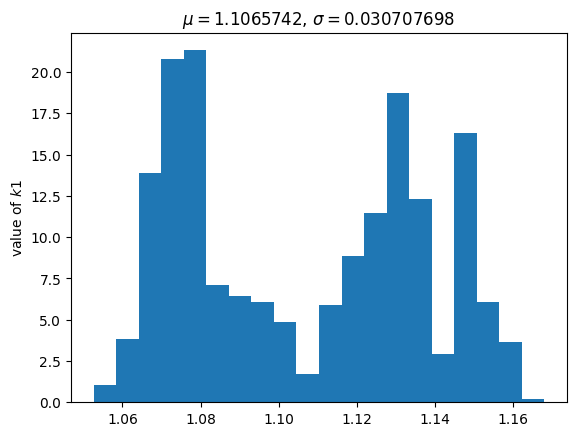

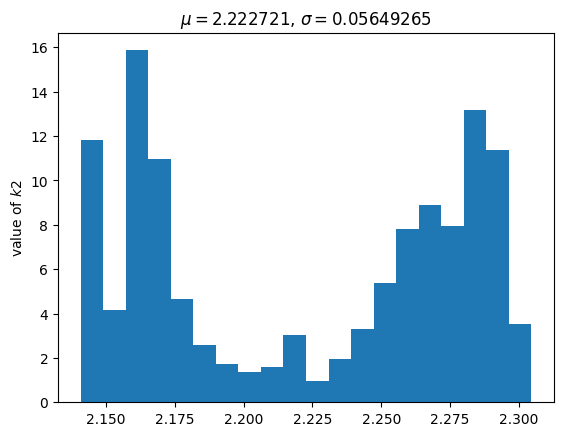

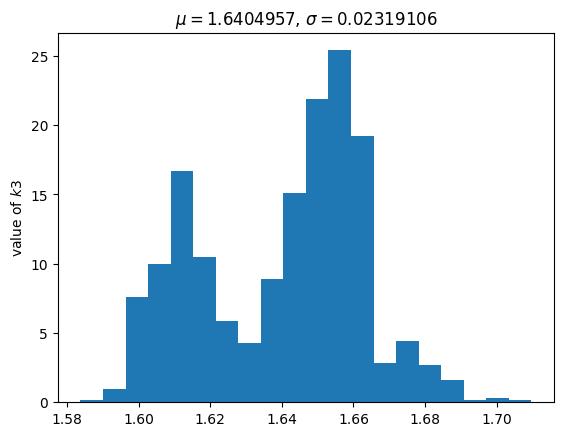

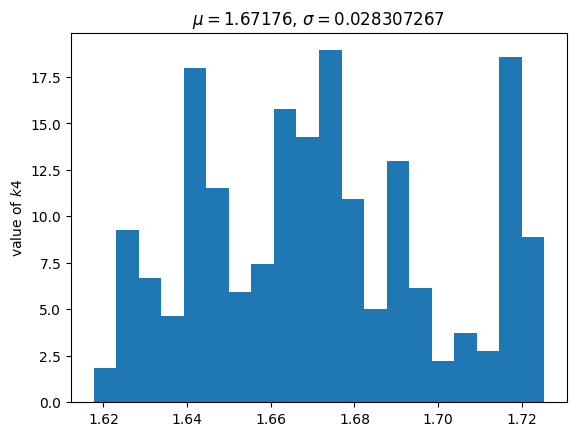

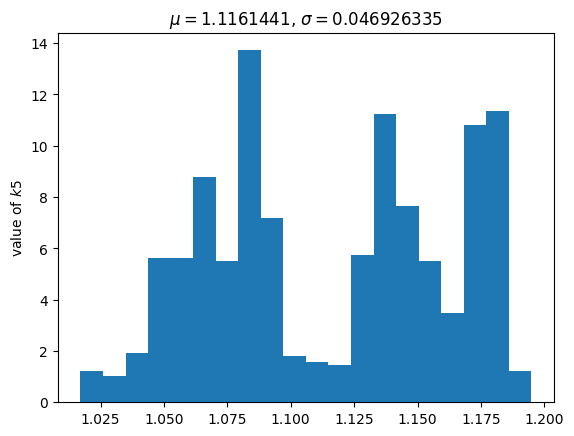

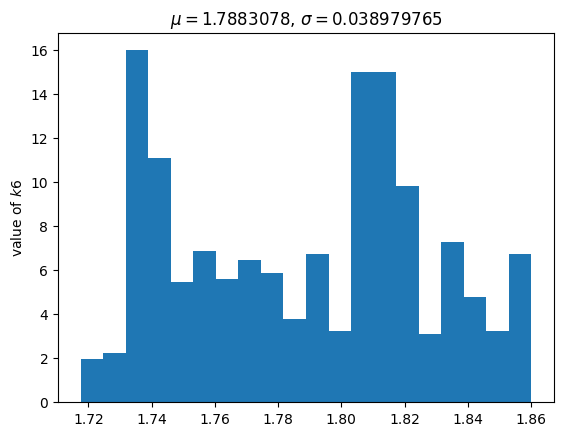

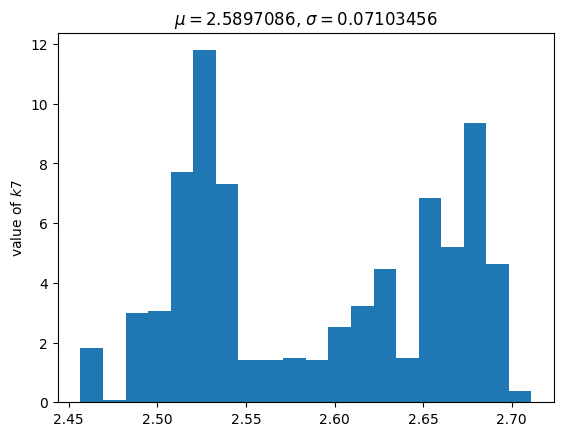

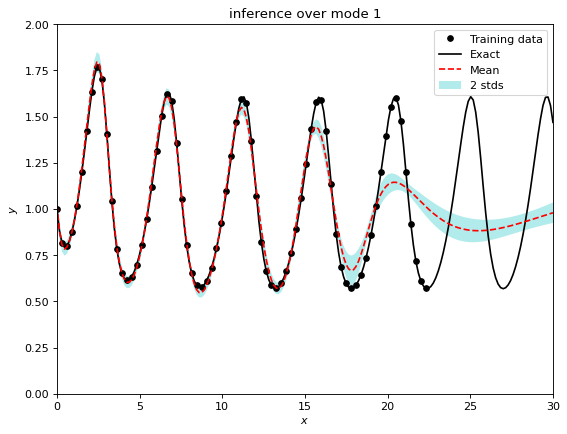

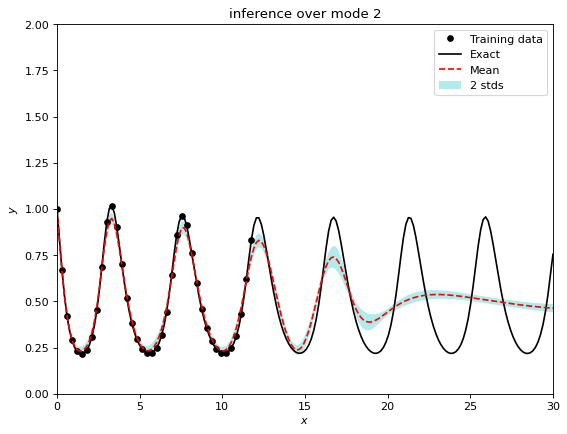

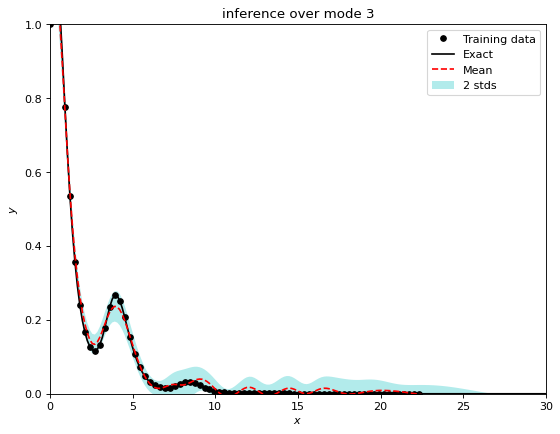

In [47]:
############################### Postprocessing ###################################
plots(u_pred, t_test, u_test, t_u_train, u_train)

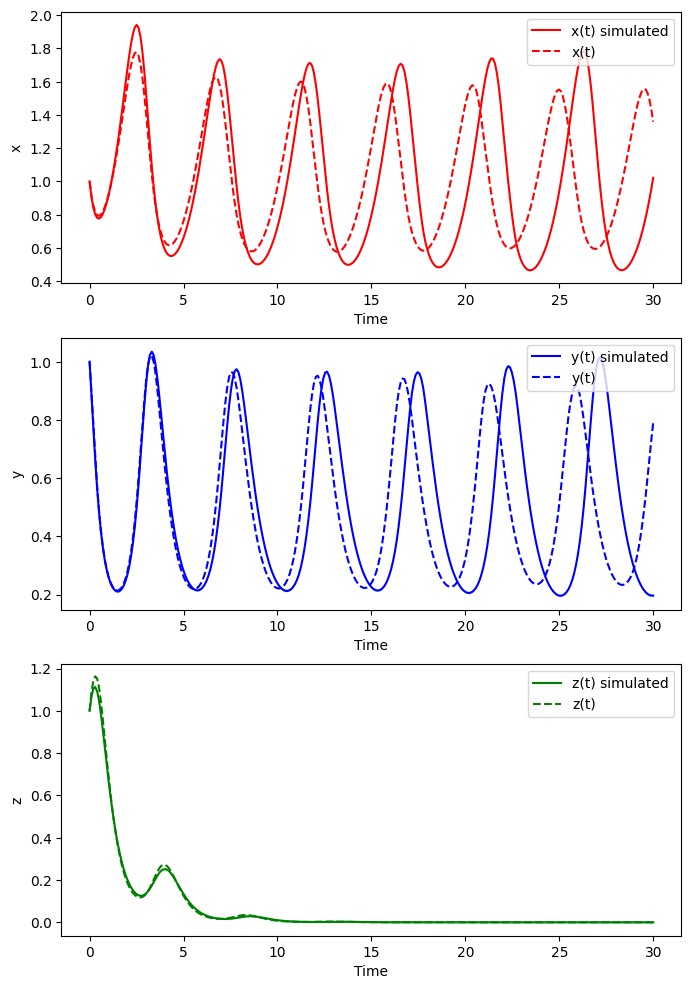

In [49]:
plot_equations2(k1_pred, k2_pred, k3_pred, k4_pred, k5_pred, k6_pred, k7_pred)